# Self-Driving Car Engineer Nanodegree


## Project: **Advenced Lane Finding** 
***

Advanced Lane Finding Project
The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.for this project.

---
**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [6]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle

%matplotlib inline

# Camera Calibration

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [3]:
#import pickle
#%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Undistortion an image
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/undist_calibration1.jpg',dst)


# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "output_images/dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Pipeline (single images)
## Ideas for Lane Detection Pipeline
**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`distortion_remover()` for undistortion image 

`binary_image_creater()` for create binary image with feature extraction  

`warp_performer()` to transoform an image to bird'S eye view

## Helper Functions

In [309]:
def distortion_remover(img):
    """ function:Removing the camera distortion from a image
        aurg1: a RGB image (with camera distortion)
        return: a RGB image (withoute camera distortion) """ 
    
    with open("output_images/dist_pickle.p", "rb") as f:
    # The pickle protocol version used is detected automatically, so we do not have to specify it.
        # Load camera calibration data
        dist_pickle = pickle.load(f)
        # Extract the calibration data
        mtx = dist_pickle["mtx"]
        dist = dist_pickle["dist"]
        
    # Undistortion an image
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=="x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient=="y":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Apply threshold
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude
    #abs_sobel = np.absolute([sobelx,sobely])
    abs_sobel = np.sqrt(sobelx*sobelx + sobely*sobely)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Apply threshold
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt(sobelx*sobelx)
    abs_sobely = np.sqrt(sobely*sobely)
    abs_sobel = np.sqrt(sobelx*sobelx + sobely*sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    sobel_angle = np.arctan2(abs_sobely, abs_sobelx)

    # Apply threshold
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(sobel_angle)
    dir_binary[(sobel_angle >= thresh[0]) & (sobel_angle <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return dir_binary

def HLS_thresh(image, channel="s_channel", hls_thresh=(170, 255)):
    """ function: HLS channel converte RGB to binary image
        arg1: original image
        arg2: channel select
        arg3: threshold value
        return: binary image with hls channel """
    # extract H or L or S channel
    # 1) Convert to HSV color space 
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    
    # 2) Separate the V channel
    if channel == "h_channel":
        hls_channel_img = hsv[:,:,0] # h_channel
    if channel == "l_channel":
        hls_channel_img = hsv[:,:,1] # l_channel
    if channel == "s_channel":
        hls_channel_img = hsv[:,:,2] # s_channel
    
    # 3) Apply threshold
    hls_binary = np.zeros_like(hls_channel_img)
    hls_binary[(hls_channel_img >= hls_thresh[0]) & (hls_channel_img <= hls_thresh[1])] = 1
    
    # 4) Return this mask as your binary_output image
    return hls_binary

def binary_image_creater(image):
    """ Function: Make binary image with image features
        arg: RGB image
        return: binary image result,
                color_binary_image (its for develop),
                binary image crated with all features (its for develop)"""
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx_binary = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady_binary = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

    # Apply each defference color channels
    S_binary   = HLS_thresh(image, channel="s_channel", hls_thresh=(170, 255))
    L_binary   = HLS_thresh(image, channel="l_channel", hls_thresh=(170, 255))

    # Combined result of Sobel_x and S-channel in HLS solor space
    color_binary = np.dstack(( np.zeros_like(gradx_binary), gradx_binary, S_binary))
    print(np.shape(color_binary))

    # Combined image SobelX and S-Channel 
    combined_image = np.zeros_like(dir_binary)
    combined_image[((gradx_binary == 1) | (S_binary == 1) )] = 1
    print(np.shape(combined_image))

    # Combined ALL image
    combined_all = np.zeros_like(dir_binary)
    combined_all[((gradx_binary == 1) & (grady_binary == 1)) \
                 | ((mag_binary == 1) & (dir_binary == 1)) | (S_binary == 1) | (L_binary == 1)] = 1
    print(np.shape(combined_all))
    
    return combined_image, color_binary, combined_all


def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    
    M    = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped, M, Minv


def warp_performer(img):
    """ function: Transform an camera viewing image into Bird's eye view
        arg: vcamera image
        retunr: an image from bird's eye view """
    # Setting the warp points
    src = np.float32(
        [[(img_size[1]  / 2) - 55 , img_size[0] / 2 + 100],
        [((img_size[1]  / 6) - 10), img_size[0]-1],
        [(img_size[1]*5 / 6) + 60 , img_size[0]-1],
        [(img_size[1]   / 2  + 55), img_size[0] / 2 + 100]])
    dst = np.float32(
        [[(img_size[1]/ 4)    , 0],
        [(img_size[1] / 4)    , img_size[0]-1],
        [(img_size[1] * 3 / 4), img_size[0]-1],
        [(img_size[1] * 3 / 4), 0]])

    # Warping the image
    warped_img, M, Minv = warper(img, src, dst)
    return warped_img, M, Minv

def calc_curvature(lefty, leftx, righty, rightx):
    """ Function: Calculate the curvature of lane lines
        arg: the position of lanelines
        return; cuvatures of left and right lanes"""
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad


def visualize_result(image, warped, Minv, left_fitx, right_fitx, ploty):
    """ Function: Visualize the result of image with lane line
        arg: warped binary image
        return: result of a undistort image with lane lines"""
    # Initialize image
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    return result 


In [323]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


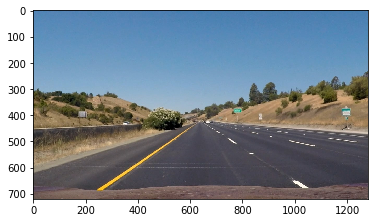

In [213]:
#reading in an image
raw_image = mpimg.imread('test_images/straight_lines1.jpg')
#image = cv2.undistort(raw_image, mtx, dist, None, mtx)

#printing out some stats and plotting
print('This image is:', type(raw_image), 'with dimensions:', raw_image.shape)
plt.imshow(raw_image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

### 1) Provide a distortion-corrected image

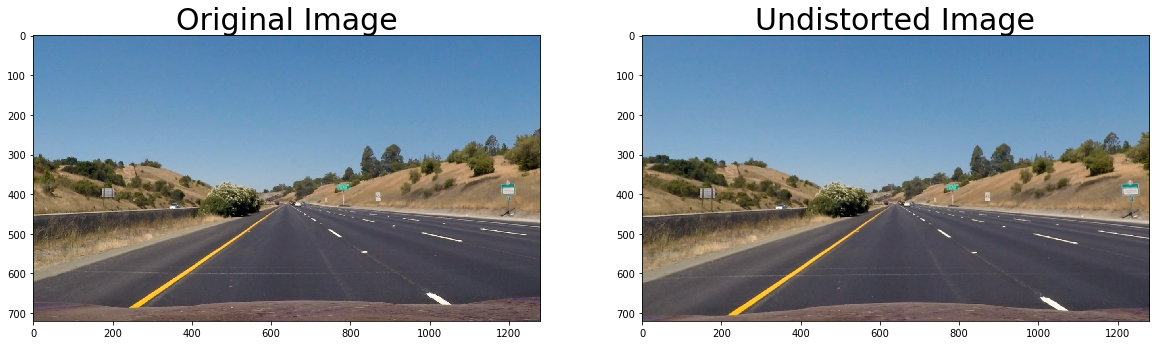

In [214]:
#reading in an image
raw_image = mpimg.imread('test_images/straight_lines1.jpg')

# Undistort a row image
image = distortion_remover(raw_image)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)

## 2) Extract a binary image

(720, 1280, 3)
(720, 1280)
(720, 1280)


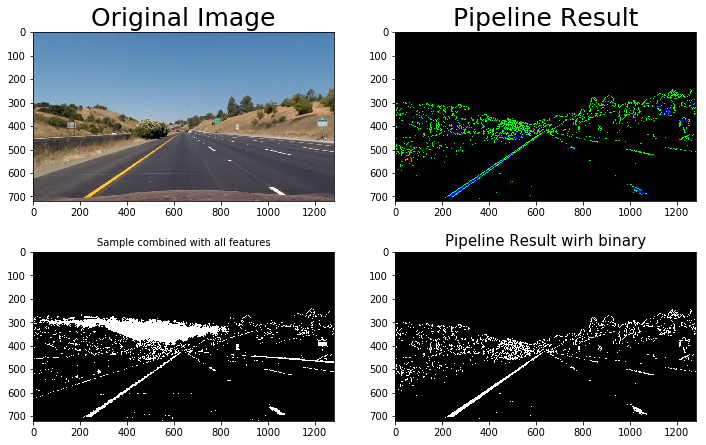

In [215]:
# Extract the features and create a binary image
combined_image, color_binary, combined_all = binary_image_creater(image)

# Plot the result with 
f, ( (ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=25)

ax2.imshow(color_binary)
ax2.set_title('Pipeline Result', fontsize=25)

ax3.imshow(combined_all, cmap='gray')
ax3.set_title('Sample combined with all features', fontsize=10)

ax4.imshow(combined_image, cmap='gray')
ax4.set_title('Pipeline Result wirh binary', fontsize=15)

plt.subplots_adjust(left=0.3, right=0.7, top=0.8, bottom=0.2, wspace=0.1, hspace=0.3)
plt.savefig("binary_image.jpg")

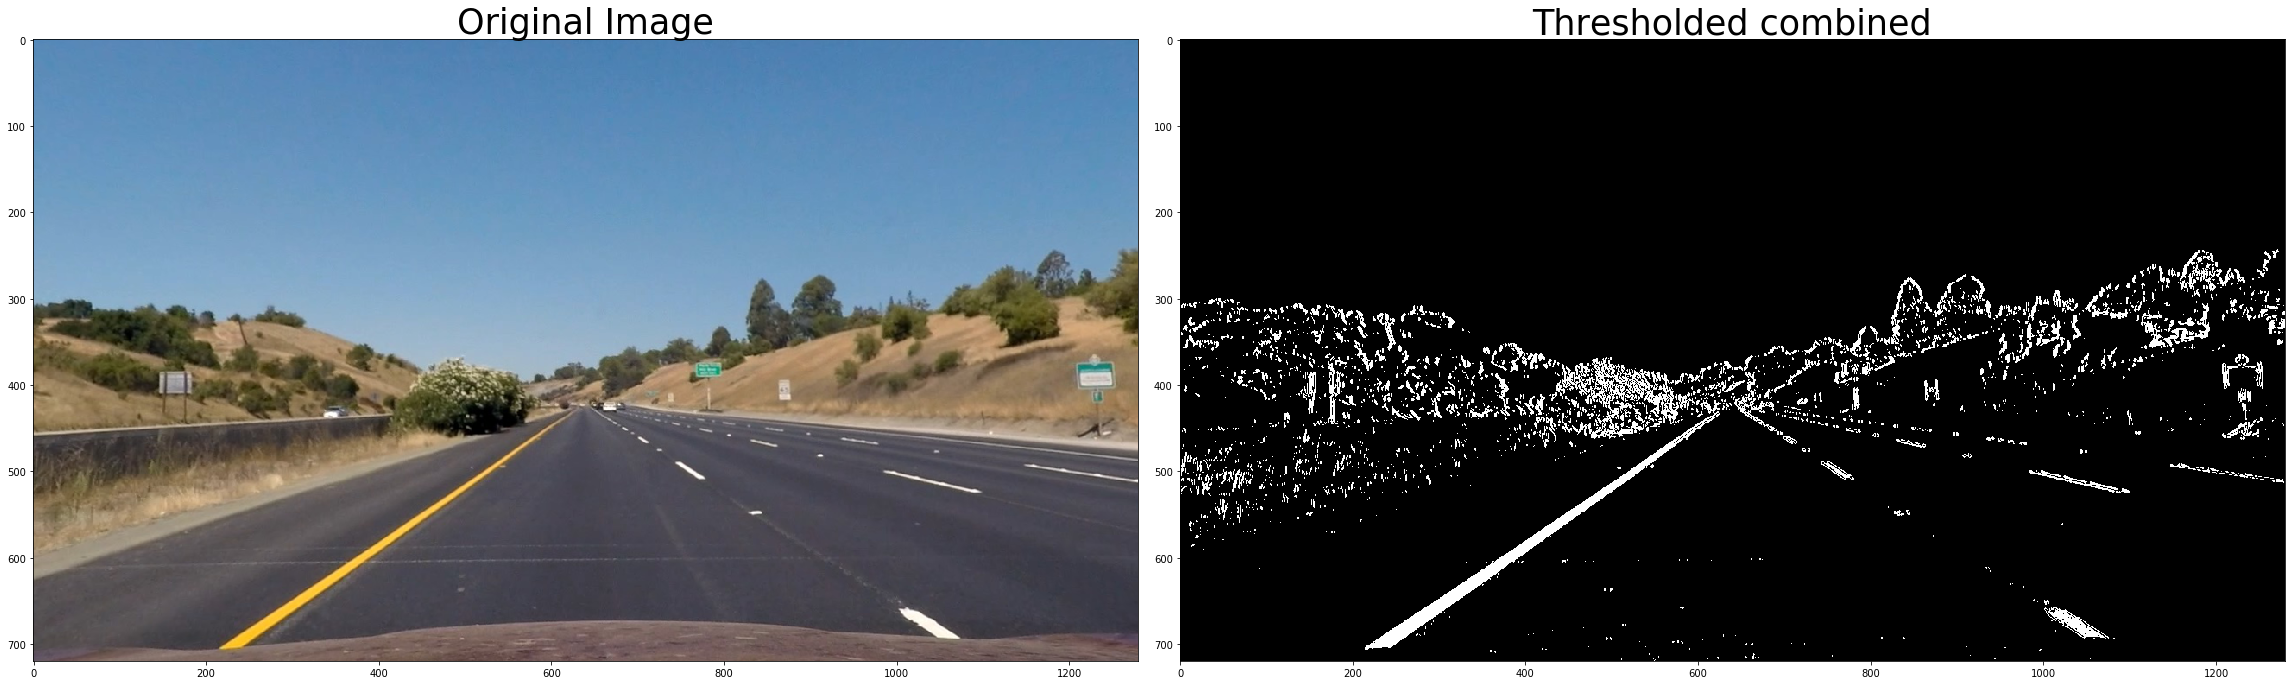

In [216]:
# Plot the result with ALL combined
f, ( (ax1, ax2)) = plt.subplots(1, 2, figsize=(24*4/3, 9*4/3))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=35)

ax2.imshow(combined_image, cmap='gray')
ax2.set_title('Thresholded combined', fontsize=35)

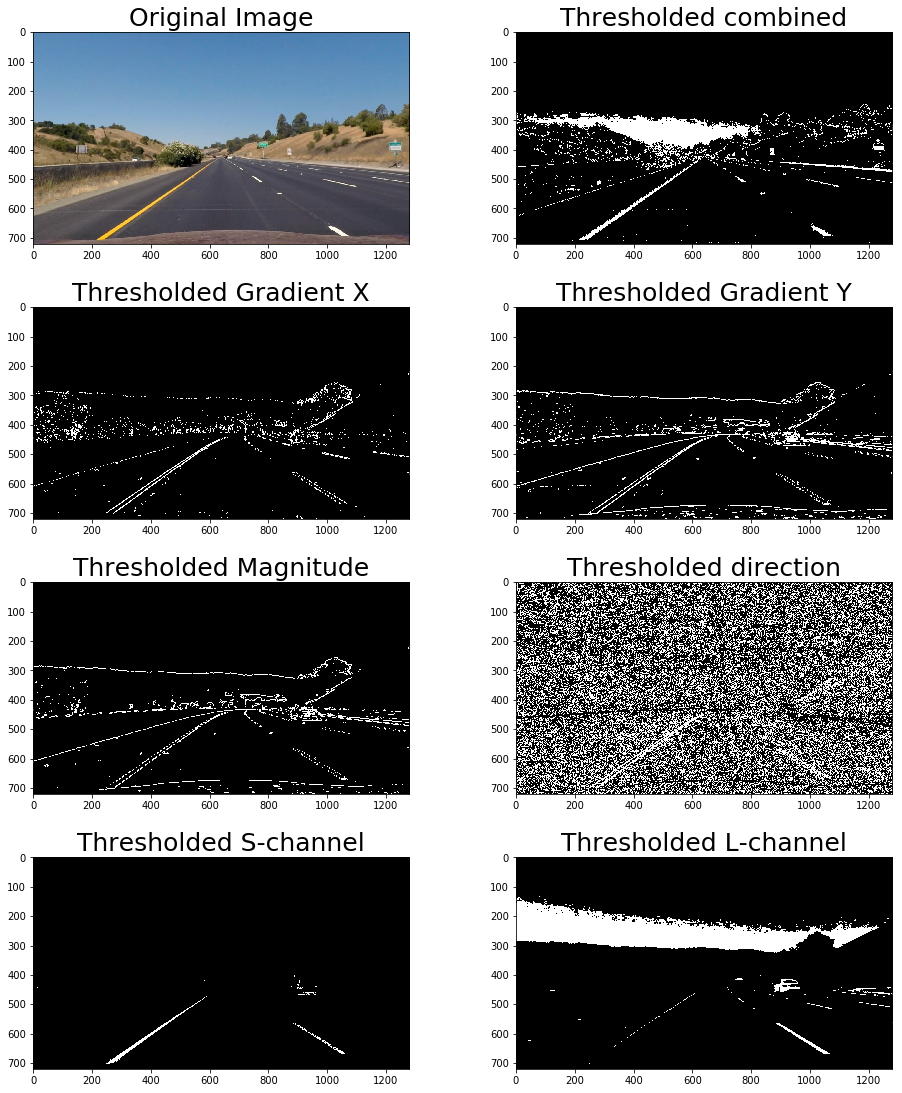

In [217]:
# Plot the result
#f, ( (ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7,ax8) ) = plt.subplots(4, 2, figsize=(24*4/3, 9*4/3))
f, ( (ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7,ax8) ) = plt.subplots(4, 2, figsize=(24*4/3*2, 9*4/3*2))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=25)

ax2.imshow(combined_all, cmap='gray')
ax2.set_title('Thresholded combined', fontsize=25)

ax3.imshow(gradx_binary, cmap='gray')
ax3.set_title('Thresholded Gradient X', fontsize=25)

ax4.imshow(grady_binary, cmap='gray')
ax4.set_title('Thresholded Gradient Y', fontsize=25)

ax5.imshow(mag_binary, cmap='gray')
ax5.set_title('Thresholded Magnitude', fontsize=25)

ax6.imshow(dir_binary, cmap='gray')
ax6.set_title('Thresholded direction', fontsize=25)

ax6.imshow(dir_binary, cmap='gray')
ax6.set_title('Thresholded direction', fontsize=25)

ax7.imshow(S_binary, cmap='gray')
ax7.set_title('Thresholded S-channel', fontsize=25)

ax8.imshow(L_binary, cmap='gray')
ax8.set_title('Thresholded L-channel', fontsize=25)

plt.subplots_adjust(left=0.4, right=0.6, top=0.8, bottom=0.2, wspace=0.1, hspace=0.3)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("extracted_image.jpg")

## 3) Perfrom a perspective image

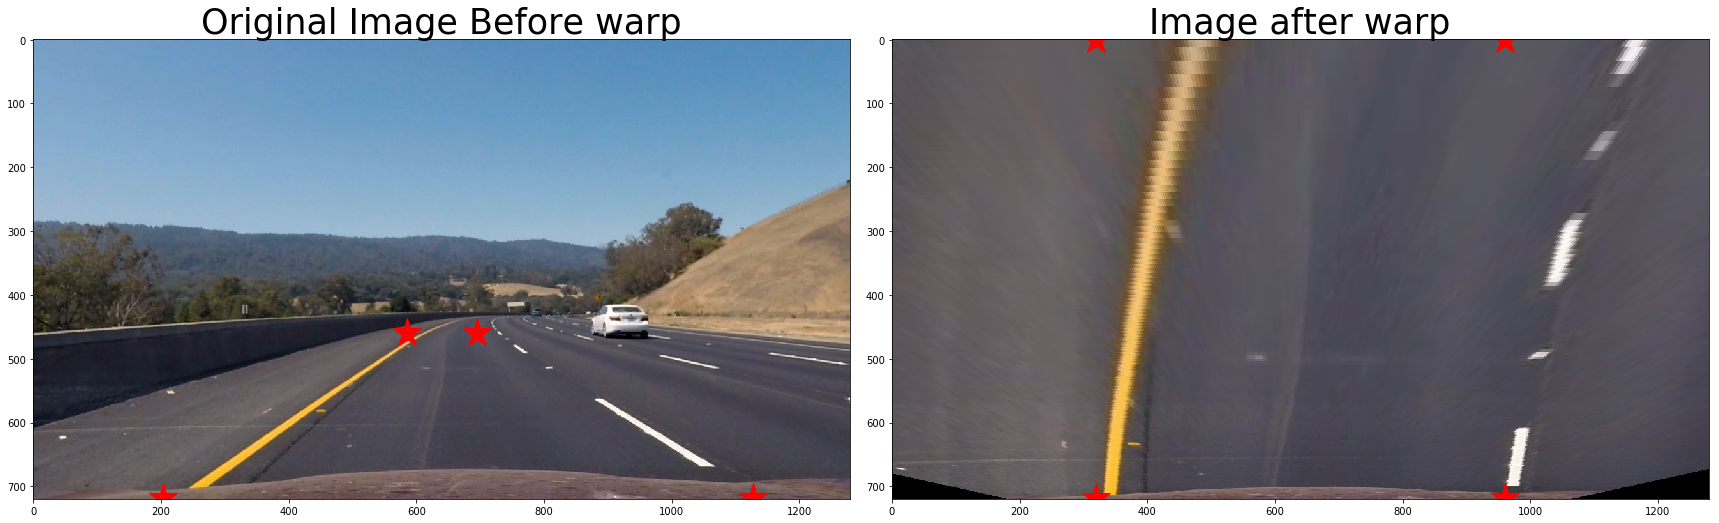

In [282]:
"""
# Read an image file
img = mpimg.imread('test_images/straight_lines1.jpg')
#img = combined
img_size = img.shape
print("Image size")
print(img_size)
"""
# Warping the image
warped_img, M, Minv = warp_performer(image)

# Plot the result
f, ( (ax1, ax2)) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image Before warp', fontsize=35)
X  = [src[0,0], src[1,0], src[2,0], src[3,0]]
Y  = [src[0,1], src[1,1], src[2,1], src[3,1]]
ax1.plot(X,Y,"r*",markersize=30)

ax2.imshow(warped_img)
ax2.set_title('Image after warp', fontsize=35)
X  = [dst[0,0], dst[1,0], dst[2,0], dst[3,0]]
Y  = [dst[0,1], dst[1,1], dst[2,1], dst[3,1]]
ax2.plot(X, Y,"r*",markersize=30)


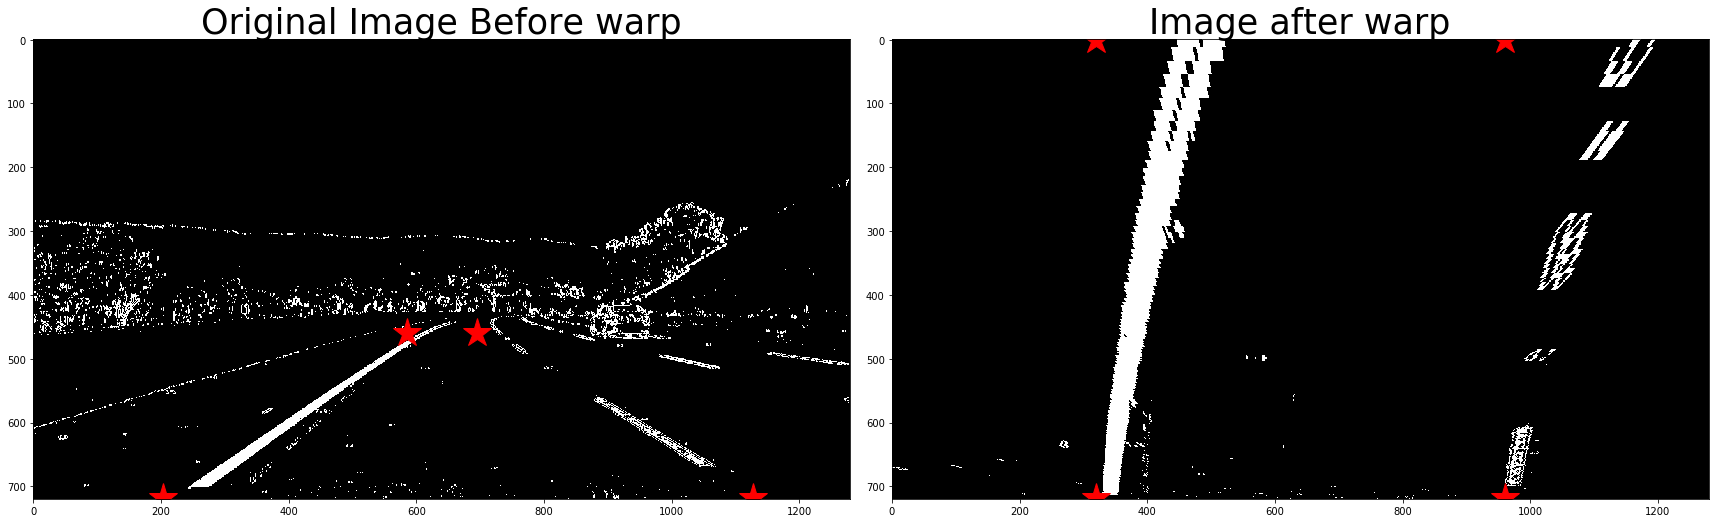

In [283]:
# Warping the image
warped_binary_img, M, Minv = warp_performer(combined_image)

# Plot the result
f, ( (ax1, ax2)) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(combined_image, cmap='gray')
ax1.set_title('Original Image Before warp', fontsize=35)
X  = [src[0,0], src[1,0], src[2,0], src[3,0]]
Y  = [src[0,1], src[1,1], src[2,1], src[3,1]]
ax1.plot(X,Y,"r*",markersize=30)

ax2.imshow(warped_binary_img, cmap='gray')
ax2.set_title('Image after warp', fontsize=35)
X  = [dst[0,0], dst[1,0], dst[2,0], dst[3,0]]
Y  = [dst[0,1], dst[1,1], dst[2,1], dst[3,1]]
ax2.plot(X, Y,"r*",markersize=30)


## 4) Find Lane Lines

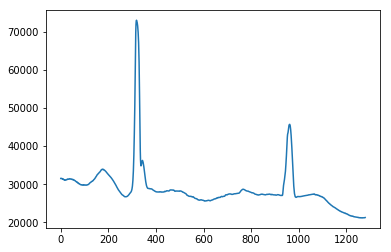

In [220]:
# Read an image file
raw_image = mpimg.imread('test_images/test3.jpg')

image = distortion_remover(raw_image)

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements
# Apply each of the thresholding functions
gradx_binary = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
# Apply each defference color channels
S_binary   = HLS_thresh(image, channel="s_channel", hls_thresh=(170, 255))

# Combined ALL image
combined_image = np.zeros_like(gradx_binary)
combined_image[((gradx_binary == 1)  | (S_binary == 1))] = 1

# Warping the image
warped_binary_img = warp_performer(combined_image)

histogram = np.sum(gray[warped_binary_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)


### Sliding Window Approach

[446 447 448 ..., 811 814 815]
left_fit
[  1.34338343e-04  -2.90087264e-01   4.81030651e+02]
right_fit
[  1.44707900e-04  -3.80212521e-01   1.16557295e+03]


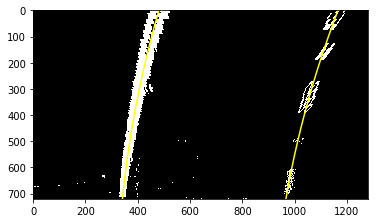

In [332]:
def calc_fit(binary_warped):
    """ Function: Find the lane line as sequential X-Y pixcels
        return  : Lane line pixcels """
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Remove -> Create an output image to draw on and  visualize the result
    
    """ Initializing the parameters
        the base point of left and right lane line"""
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    """ the Sliding window settings """
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    """ the Sliding window settings """
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    print(nonzerox)

    """ the Sliding window settings """
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):

        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Remove -> Draw the windows on the visualization image
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds= ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                          (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx_for_fit  = nonzerox[left_lane_inds]
    lefty_for_fit  = nonzeroy[left_lane_inds] 
    rightx_for_fit = nonzerox[right_lane_inds]
    righty_for_fit = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit  = np.polyfit(lefty_for_fit,   leftx_for_fit, 2)
    right_fit = np.polyfit(righty_for_fit, rightx_for_fit, 2)
    
    # Generate x and y values for plotting
    # Make y-value for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Calculate the x-value for y-value
    left_fitx  = left_fit[0] *ploty**2 + left_fit[1] *ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Remove -> paint colors on lane line image
    return left_fit, right_fit, ploty, left_fitx, right_fitx


# Find the lane line with sliding windows
left_fit, right_fit, ploty, left_fitx, right_fitx = calc_fit(warped_binary_img)

# Ready fot the test plot
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped_binary_img, warped_binary_img, warped_binary_img))*255

plt.imshow(out_img)
plt.plot(left_fitx,  ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
# Debug
print("left_fit")
print(left_fit)
print("right_fit")
print(right_fit)

binary_warped.shape
(720, 1280)
[446 447 448 ..., 811 814 815]
left_fit
[  1.34338343e-04  -2.90087264e-01   4.81030651e+02]
right_fit
[  1.44707900e-04  -3.80212521e-01   1.16557295e+03]


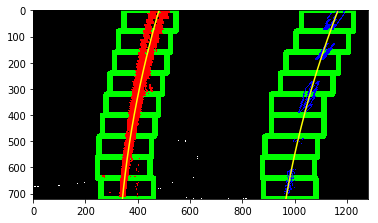

In [325]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

binary_warped = warped_binary_img
print("binary_warped.shape")
print(binary_warped.shape)

def calc_fit(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    print(nonzerox)

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):

        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 20) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 20) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds= ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                          (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # paint colors on lane line image
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return left_fit, right_fit, ploty, left_fitx, right_fitx, out_img


# Find the lane line with sliding windows
left_fit, right_fit, ploty, left_fitx, right_fitx, out_img = calc_fit(warped_binary_img)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
# Debug
print("left_fit")
print(left_fit)
print("right_fit")
print(right_fit)

In [333]:
def calc_fit_assume(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx_for_fit  = nonzerox[left_lane_inds]
    lefty_for_fit  = nonzeroy[left_lane_inds] 
    rightx_for_fit = nonzerox[right_lane_inds]
    righty_for_fit = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty_for_fit,   leftx_for_fit, 2)
    right_fit = np.polyfit(righty_for_fit, rightx_for_fit, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx  = left_fit[0] *ploty**2 + left_fit[1] *ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, right_fit, ploty, left_fitx, right_fitx

# Find the lane line with assuming
left_fit, right_fit, ploty, left_fitx, right_fitx = calc_fit_assume(warped_binary_img, left_fit, right_fit)

#print("ploty")
#print(ploty)
print("lefty")
print(len(lefty))
print("leftx")
print(len(leftx))

print("left_fitx")
print(left_fit)
print("right_fitx")
print(right_fit)

lefty
34246
leftx
34246
left_fitx
[  1.33863027e-04  -2.89832752e-01   4.81009894e+02]
right_fitx
[  1.43621573e-04  -3.79659326e-01   1.16553136e+03]


(720, 0)

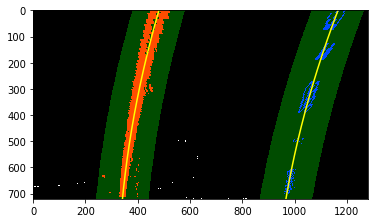

In [296]:
# Test plot

binary_warped = warped_binary_img
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [247]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48 [pixcel]

3774.49935344 3609.9162444


In [311]:
# Calculate the curvature
"""
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

return left_curverad, right_curverad
"""
left_curvature, right_curvature =  calc_curvature(lefty, leftx, righty, rightx)
# Now our radius of curvature is in meters
print(left_curvature, 'm', right_curvature, 'm')

1222.76302356 m 1135.69602886 m


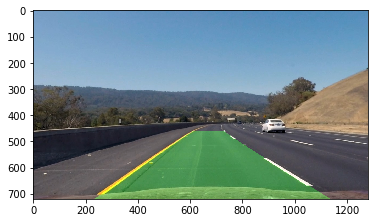

In [308]:
"""
# Create an image to draw the lines on
# Initialize image
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

plt.imshow(result)
"""
# Create the visualization with Function
result =  visualize_result(image, warped_binary_img, Minv, left_fitx, right_fitx, ploty)
# Visualize
plt.imshow(result)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In this process thet target file is straight_lines2.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


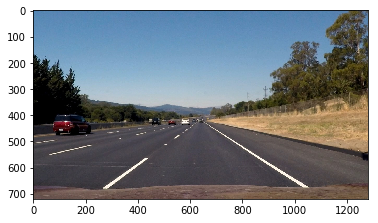

In [264]:
import os
images = os.listdir("test_images/")

#print(images)
src_img = images[1]
print("In this process thet target file is "+src_img)
#reading in an image
img = mpimg.imread("test_images/"+src_img)

#printing out some stats and plotting
print('This image is:', type(img), 'with dimensions:', img.shape)
plt.imshow(img)
# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Build a Lane Finding Pipeline



This is the pipeline for Finding Lane Line on all test_images. 

In [315]:
# Pipeline main process
isFindLane = False

def process_image(raw_image):
    isFindLane = False
    # Undistort a raw image
    image = distortion_remover(raw_image)
    # Extract the features and create a binary image
    combined_image, color_binary, combined_all = binary_image_creater(image)
    # Warping the image
    warped_binary_img, M, Minv = warp_performer(combined_image)
    
    if isFindLane == False:
        # Find the lane line with sliding windows
        left_fit, right_fit, ploty, left_fitx, right_fitx, out_img = calc_fit(warped_binary_img)
        isFindLane = True
    else:
        # Find the lane line with assuming
        left_fit, right_fit, left_fitx, right_fitx = calc_fit_assume(warped_binary_img, left_fit, right_fit)
    
    # calculate the curvature    
    left_curvature, right_curvature =  calc_curvature(lefty, leftx, righty, rightx)
    print("left_curvature[m]")
    print(left_curvature)
    print("right_curvature[m]")
    print(right_curvature)
    # reverse the image with camera image
    result = visualize_result(image, warped, Minv, left_fitx, right_fitx, ploty)
    # return an image with lane line
    return result


(720, 1280, 3)
(720, 1280)
(720, 1280)
[131 132 133 ..., 894 895 896]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


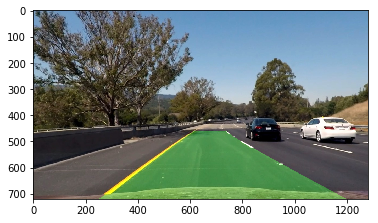

In [316]:
# Read an image file
raw_image = mpimg.imread('test_images/test6.jpg')

result = process_image(raw_image)
plt.imshow(result)

## Test for Pipeline on Videos

In this cell, Drawing lanes over video!
I evaluate my solution on 3 provided videos:

`project.mp4`

`challenge.mp4`

`harder_challenge.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [317]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## 1) Project.mp4

In [318]:
white_output = 'output_images/project.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 38  39  40 ..., 921 923 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886
[MoviePy] >>>> Building video output_images/project.mp4
[MoviePy] Writing video output_images/project.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 38  39  40 ..., 921 923 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  0%|                                                                                 | 1/1261 [00:00<05:52,  3.58it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[213 214 215 ..., 385 438 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  0%|▏                                                                                | 2/1261 [00:00<05:59,  3.50it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[213 214 215 ..., 438 836 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  0%|▏                                                                                | 3/1261 [00:00<06:20,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[213 214 215 ..., 438 836 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  0%|▎                                                                                | 4/1261 [00:01<06:20,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[207 208 209 ..., 684 837 904]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  0%|▎                                                                                | 5/1261 [00:01<06:18,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[207 208 209 ..., 386 560 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  0%|▍                                                                                | 6/1261 [00:01<06:10,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[207 208 209 ..., 920 923 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  1%|▍                                                                                | 7/1261 [00:02<06:08,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[207 208 209 ..., 438 560 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  1%|▌                                                                                | 8/1261 [00:02<06:05,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 385 386 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  1%|▌                                                                                | 9/1261 [00:02<06:22,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[195 196 197 ..., 622 886 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  1%|▋                                                                               | 10/1261 [00:02<06:12,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[195 196 197 ..., 455 561 623]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  1%|▋                                                                               | 11/1261 [00:03<06:07,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 885 385 923]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  1%|▊                                                                               | 12/1261 [00:03<06:01,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 886 384 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  1%|▊                                                                               | 13/1261 [00:03<06:07,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 886 384 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  1%|▉                                                                               | 14/1261 [00:04<06:06,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[195 196 197 ..., 886 892 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  1%|▉                                                                               | 15/1261 [00:04<06:04,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[195 196 197 ..., 808 826 847]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  1%|█                                                                               | 16/1261 [00:04<06:03,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[195 196 197 ..., 385 561 847]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  1%|█                                                                               | 17/1261 [00:05<06:05,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[195 196 197 ..., 533 833 847]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  1%|█▏                                                                              | 18/1261 [00:05<06:04,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 885 385 437]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  2%|█▏                                                                              | 19/1261 [00:05<05:57,  3.48it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 926 438 847]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  2%|█▎                                                                              | 20/1261 [00:05<05:55,  3.49it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 680 684 847]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  2%|█▎                                                                              | 21/1261 [00:06<06:00,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 613 614 679]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  2%|█▍                                                                              | 22/1261 [00:06<05:58,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 928 614 679]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  2%|█▍                                                                              | 23/1261 [00:06<05:56,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 834 835 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  2%|█▌                                                                              | 24/1261 [00:07<05:52,  3.51it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 611 643 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  2%|█▌                                                                              | 25/1261 [00:07<05:52,  3.51it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 885 886 925]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  2%|█▋                                                                              | 26/1261 [00:07<05:56,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 613 835 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  2%|█▋                                                                              | 27/1261 [00:07<05:53,  3.49it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 923 926 927]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  2%|█▊                                                                              | 28/1261 [00:08<05:51,  3.50it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 684 923 964]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  2%|█▊                                                                              | 29/1261 [00:08<05:49,  3.52it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 684 685 964]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  2%|█▉                                                                              | 30/1261 [00:08<05:48,  3.53it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 683 978 979]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  2%|█▉                                                                              | 31/1261 [00:09<05:48,  3.52it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 636 846 978]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  3%|██                                                                              | 32/1261 [00:09<05:54,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 811 945 979]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  3%|██                                                                              | 33/1261 [00:09<05:53,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 835 885 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  3%|██▏                                                                             | 34/1261 [00:09<05:51,  3.49it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 835 848 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  3%|██▏                                                                             | 35/1261 [00:10<05:44,  3.56it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 926 386 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  3%|██▎                                                                             | 36/1261 [00:10<05:45,  3.54it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 834 835 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  3%|██▎                                                                             | 37/1261 [00:10<05:40,  3.59it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 835 385 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  3%|██▍                                                                             | 38/1261 [00:11<05:43,  3.56it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 885 886 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  3%|██▍                                                                             | 39/1261 [00:11<05:42,  3.57it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 645 885 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  3%|██▌                                                                             | 40/1261 [00:11<05:43,  3.55it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 885 890 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  3%|██▌                                                                             | 41/1261 [00:11<05:44,  3.54it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 644 835 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  3%|██▋                                                                             | 42/1261 [00:12<05:44,  3.53it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 886 683 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  3%|██▋                                                                             | 43/1261 [00:12<05:51,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 644 835 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  3%|██▊                                                                             | 44/1261 [00:12<05:55,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 835 385 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  4%|██▊                                                                             | 45/1261 [00:13<05:52,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 886 385 636]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  4%|██▉                                                                             | 46/1261 [00:13<05:50,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[166 167 168 ..., 385 636 683]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  4%|██▉                                                                             | 47/1261 [00:13<05:46,  3.51it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[166 167 168 ..., 562 644 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  4%|███                                                                             | 48/1261 [00:13<05:50,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[166 167 168 ..., 835 886 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  4%|███                                                                             | 49/1261 [00:14<05:53,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[166 167 168 ..., 835 887 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  4%|███▏                                                                            | 50/1261 [00:14<05:49,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[166 167 168 ..., 561 562 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  4%|███▏                                                                            | 51/1261 [00:14<05:53,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[166 167 168 ..., 562 835 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  4%|███▎                                                                            | 52/1261 [00:15<05:50,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 890 891 560]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  4%|███▎                                                                            | 53/1261 [00:15<05:48,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 562 644 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  4%|███▍                                                                            | 54/1261 [00:15<05:52,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 644 885 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  4%|███▍                                                                            | 55/1261 [00:15<05:55,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 644 885 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  4%|███▌                                                                            | 56/1261 [00:16<05:51,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 561 886 925]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  5%|███▌                                                                            | 57/1261 [00:16<05:54,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 561 562 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  5%|███▋                                                                            | 58/1261 [00:16<06:13,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 562 834 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  5%|███▋                                                                            | 59/1261 [00:17<06:23,  3.14it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 561 644 529]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  5%|███▊                                                                            | 60/1261 [00:17<06:16,  3.19it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 885 886 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  5%|███▊                                                                            | 61/1261 [00:17<06:17,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 886 891 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  5%|███▉                                                                            | 62/1261 [00:18<06:11,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 885 886 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  5%|███▉                                                                            | 63/1261 [00:18<06:08,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 611 885 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  5%|████                                                                            | 64/1261 [00:18<05:59,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 611 835 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  5%|████                                                                            | 65/1261 [00:19<06:01,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 885 886 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  5%|████▏                                                                           | 66/1261 [00:19<05:59,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 886 891 916]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  5%|████▎                                                                           | 67/1261 [00:19<05:59,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 885 886 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  5%|████▎                                                                           | 68/1261 [00:19<05:58,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 885 886 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  5%|████▍                                                                           | 69/1261 [00:20<05:58,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 611 886 560]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  6%|████▍                                                                           | 70/1261 [00:20<05:52,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 452 561 611]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  6%|████▌                                                                           | 71/1261 [00:20<05:47,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 704 705 561]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  6%|████▌                                                                           | 72/1261 [00:21<05:44,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 705 561 610]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  6%|████▋                                                                           | 73/1261 [00:21<05:42,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 611 885 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  6%|████▋                                                                           | 74/1261 [00:21<05:39,  3.50it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 610 611 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  6%|████▊                                                                           | 75/1261 [00:21<05:38,  3.50it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 561 610 611]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  6%|████▊                                                                           | 76/1261 [00:22<05:38,  3.50it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 423 424 533]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  6%|████▉                                                                           | 77/1261 [00:22<05:37,  3.51it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 561 562 680]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  6%|████▉                                                                           | 78/1261 [00:22<05:37,  3.51it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 423 424 454]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  6%|█████                                                                           | 79/1261 [00:23<05:42,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 453 835 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  6%|█████                                                                           | 80/1261 [00:23<05:40,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 452 453 561]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  6%|█████▏                                                                          | 81/1261 [00:23<05:36,  3.50it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 561 644 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  7%|█████▏                                                                          | 82/1261 [00:23<05:41,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 453 835 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  7%|█████▎                                                                          | 83/1261 [00:24<05:39,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 528 835 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  7%|█████▎                                                                          | 84/1261 [00:24<05:38,  3.48it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 528 835 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  7%|█████▍                                                                          | 85/1261 [00:24<05:42,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 528 835 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  7%|█████▍                                                                          | 86/1261 [00:25<05:40,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 385 684 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  7%|█████▌                                                                          | 87/1261 [00:25<05:38,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 611 385 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  7%|█████▌                                                                          | 88/1261 [00:25<05:36,  3.48it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[195 196 197 ..., 885 891 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  7%|█████▋                                                                          | 89/1261 [00:25<05:46,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 529 530 565]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  7%|█████▋                                                                          | 90/1261 [00:26<05:48,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 611 643 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  7%|█████▊                                                                          | 91/1261 [00:26<05:43,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 561 562 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  7%|█████▊                                                                          | 92/1261 [00:26<05:37,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 562 643 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  7%|█████▉                                                                          | 93/1261 [00:27<05:36,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 561 562 643]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  7%|█████▉                                                                          | 94/1261 [00:27<05:34,  3.49it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 704 561 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  8%|██████                                                                          | 95/1261 [00:27<05:33,  3.49it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 561 562 611]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  8%|██████                                                                          | 96/1261 [00:27<05:33,  3.50it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 611 643 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  8%|██████▏                                                                         | 97/1261 [00:28<05:32,  3.50it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[195 196 197 ..., 452 561 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  8%|██████▏                                                                         | 98/1261 [00:28<05:29,  3.53it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 562 643 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  8%|██████▎                                                                         | 99/1261 [00:28<05:37,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 452 561 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  8%|██████▎                                                                        | 100/1261 [00:29<05:36,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 561 562 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  8%|██████▎                                                                        | 101/1261 [00:29<05:36,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 561 562 643]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  8%|██████▍                                                                        | 102/1261 [00:29<05:36,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 561 562 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  8%|██████▍                                                                        | 103/1261 [00:30<05:33,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 561 623 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  8%|██████▌                                                                        | 104/1261 [00:30<05:31,  3.49it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 644 835 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  8%|██████▌                                                                        | 105/1261 [00:30<05:30,  3.49it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 835 886 998]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  8%|██████▋                                                                        | 106/1261 [00:30<05:35,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[195 196 197 ..., 423 644 927]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  8%|██████▋                                                                        | 107/1261 [00:31<05:33,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 562 835 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  9%|██████▊                                                                        | 108/1261 [00:31<05:31,  3.48it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 834 835 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  9%|██████▊                                                                        | 109/1261 [00:31<05:33,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 614 636 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  9%|██████▉                                                                        | 110/1261 [00:32<05:26,  3.53it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 644 885 890]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  9%|██████▉                                                                        | 111/1261 [00:32<05:26,  3.52it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 562 835 613]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  9%|███████                                                                        | 112/1261 [00:32<05:26,  3.52it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 420 561 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  9%|███████                                                                        | 113/1261 [00:32<05:26,  3.51it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 561 562 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  9%|███████▏                                                                       | 114/1261 [00:33<05:32,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[207 208 209 ..., 559 561 643]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  9%|███████▏                                                                       | 115/1261 [00:33<05:30,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[207 208 209 ..., 643 885 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  9%|███████▎                                                                       | 116/1261 [00:33<05:33,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[207 208 209 ..., 558 561 611]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  9%|███████▎                                                                       | 117/1261 [00:34<05:29,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 422 425 561]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  9%|███████▍                                                                       | 118/1261 [00:34<05:28,  3.48it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 643 885 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


  9%|███████▍                                                                       | 119/1261 [00:34<05:23,  3.53it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 223 446 529]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 10%|███████▌                                                                       | 120/1261 [00:34<05:29,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 623 644 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 10%|███████▌                                                                       | 121/1261 [00:35<05:33,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 623 644 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 10%|███████▋                                                                       | 122/1261 [00:35<05:30,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 21  22  23 ..., 561 623 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 10%|███████▋                                                                       | 123/1261 [00:35<05:33,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 15  16  17 ..., 880 561 623]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 10%|███████▊                                                                       | 124/1261 [00:36<05:35,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 27  28  29 ..., 456 561 623]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 10%|███████▊                                                                       | 125/1261 [00:36<05:37,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 15  16  17 ..., 421 561 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 10%|███████▉                                                                       | 126/1261 [00:36<05:38,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 15  16  17 ..., 561 562 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 10%|███████▉                                                                       | 127/1261 [00:36<05:31,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 420 421 424]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 10%|████████                                                                       | 128/1261 [00:37<05:34,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 452 561 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 10%|████████                                                                       | 129/1261 [00:37<05:30,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 561 562 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 10%|████████▏                                                                      | 130/1261 [00:37<05:32,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 561 562 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 10%|████████▏                                                                      | 131/1261 [00:38<05:29,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 452 456 561]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 10%|████████▎                                                                      | 132/1261 [00:38<05:25,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 452 561 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 11%|████████▎                                                                      | 133/1261 [00:38<05:23,  3.48it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 562 891 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 11%|████████▍                                                                      | 134/1261 [00:38<05:23,  3.48it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 562 891 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 11%|████████▍                                                                      | 135/1261 [00:39<05:19,  3.52it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 385 438 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 11%|████████▌                                                                      | 136/1261 [00:39<05:19,  3.52it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 891 385 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 11%|████████▌                                                                      | 137/1261 [00:39<05:19,  3.52it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 644 685 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 11%|████████▋                                                                      | 138/1261 [00:40<05:19,  3.51it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 438 529 636]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 11%|████████▋                                                                      | 139/1261 [00:40<05:19,  3.51it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 891 385 636]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 11%|████████▊                                                                      | 140/1261 [00:40<05:18,  3.52it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 385 438 636]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 11%|████████▊                                                                      | 141/1261 [00:40<05:18,  3.52it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 562 611 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 11%|████████▉                                                                      | 142/1261 [00:41<05:20,  3.49it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[207 208 209 ..., 926 385 636]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 11%|████████▉                                                                      | 143/1261 [00:41<05:23,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[207 208 209 ..., 924 385 636]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 11%|█████████                                                                      | 144/1261 [00:41<05:23,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[207 208 209 ..., 611 623 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 11%|█████████                                                                      | 145/1261 [00:42<05:16,  3.52it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[213 214 215 ..., 644 529 923]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 12%|█████████▏                                                                     | 146/1261 [00:42<05:22,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[213 214 215 ..., 623 644 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 12%|█████████▏                                                                     | 147/1261 [00:42<05:20,  3.48it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[219 220 221 ..., 643 644 566]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 12%|█████████▎                                                                     | 148/1261 [00:42<05:19,  3.49it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[219 220 221 ..., 643 644 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 12%|█████████▎                                                                     | 149/1261 [00:43<05:23,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[219 220 221 ..., 623 643 445]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 12%|█████████▍                                                                     | 150/1261 [00:43<05:15,  3.52it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[213 214 215 ..., 644 438 529]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 12%|█████████▍                                                                     | 151/1261 [00:43<05:20,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[213 214 215 ..., 644 385 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 12%|█████████▌                                                                     | 152/1261 [00:44<05:23,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[213 214 215 ..., 562 566 923]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 12%|█████████▌                                                                     | 153/1261 [00:44<05:24,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[213 214 215 ..., 644 438 529]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 12%|█████████▋                                                                     | 154/1261 [00:44<05:24,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[207 208 209 ..., 561 644 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 12%|█████████▋                                                                     | 155/1261 [00:45<05:19,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 644 891 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 12%|█████████▊                                                                     | 156/1261 [00:45<05:16,  3.49it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 926 385 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 12%|█████████▊                                                                     | 157/1261 [00:45<05:14,  3.51it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 644 891 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 13%|█████████▉                                                                     | 158/1261 [00:45<05:14,  3.51it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 644 926 560]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 13%|█████████▉                                                                     | 159/1261 [00:46<05:13,  3.51it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[195 196 197 ..., 886 891 560]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 13%|██████████                                                                     | 160/1261 [00:46<05:20,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 644 438 560]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 13%|██████████                                                                     | 161/1261 [00:46<05:17,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 644 438 560]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 13%|██████████▏                                                                    | 162/1261 [00:47<05:33,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 560 583 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 13%|██████████▏                                                                    | 163/1261 [00:47<05:40,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 583 683 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 13%|██████████▎                                                                    | 164/1261 [00:47<05:36,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 562 644 560]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 13%|██████████▎                                                                    | 165/1261 [00:47<05:27,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 583 683 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 13%|██████████▍                                                                    | 166/1261 [00:48<05:22,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 385 438 560]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 13%|██████████▍                                                                    | 167/1261 [00:48<05:20,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 644 438 683]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 13%|██████████▌                                                                    | 168/1261 [00:48<05:15,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 562 644 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 13%|██████████▌                                                                    | 169/1261 [00:49<05:13,  3.48it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 562 438 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 13%|██████████▋                                                                    | 170/1261 [00:49<05:12,  3.49it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 644 385 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 14%|██████████▋                                                                    | 171/1261 [00:49<05:18,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 562 385 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 14%|██████████▊                                                                    | 172/1261 [00:50<05:18,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 644 900 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 14%|██████████▊                                                                    | 173/1261 [00:50<05:19,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 558 561 900]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 14%|██████████▉                                                                    | 174/1261 [00:50<05:27,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 886 900 560]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 14%|██████████▉                                                                    | 175/1261 [00:50<05:20,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 705 561 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 14%|███████████                                                                    | 176/1261 [00:51<05:17,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[166 167 168 ..., 561 885 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 14%|███████████                                                                    | 177/1261 [00:51<05:18,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[166 167 168 ..., 705 561 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 14%|███████████▏                                                                   | 178/1261 [00:51<05:15,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[166 167 168 ..., 561 623 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 14%|███████████▏                                                                   | 179/1261 [00:52<05:18,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[166 167 168 ..., 561 886 921]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 14%|███████████▎                                                                   | 180/1261 [00:52<05:16,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 425 561 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 14%|███████████▎                                                                   | 181/1261 [00:52<05:18,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 561 562 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 14%|███████████▍                                                                   | 182/1261 [00:52<05:19,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 611 644 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 15%|███████████▍                                                                   | 183/1261 [00:53<05:20,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 562 644 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 15%|███████████▌                                                                   | 184/1261 [00:53<05:16,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 452 561 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 15%|███████████▌                                                                   | 185/1261 [00:53<05:11,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 644 438 533]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 15%|███████████▋                                                                   | 186/1261 [00:54<05:04,  3.53it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 561 622 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 15%|███████████▋                                                                   | 187/1261 [00:54<05:09,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 622 644 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 15%|███████████▊                                                                   | 188/1261 [00:54<05:08,  3.48it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 644 438 748]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 15%|███████████▊                                                                   | 189/1261 [00:54<05:12,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 891 438 748]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 15%|███████████▉                                                                   | 190/1261 [00:55<05:10,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 452 561 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 15%|███████████▉                                                                   | 191/1261 [00:55<05:06,  3.49it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 748 759 920]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 15%|████████████                                                                   | 192/1261 [00:55<05:11,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 438 759 992]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 15%|████████████                                                                   | 193/1261 [00:56<05:05,  3.50it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 684 748 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 15%|████████████▏                                                                  | 194/1261 [00:56<05:04,  3.50it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 438 748 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 15%|████████████▏                                                                  | 195/1261 [00:56<05:04,  3.50it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 891 748 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 16%|████████████▎                                                                  | 196/1261 [00:56<05:08,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 644 748 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 16%|████████████▎                                                                  | 197/1261 [00:57<05:21,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[166 167 168 ..., 891 748 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 16%|████████████▍                                                                  | 198/1261 [00:57<05:32,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[160 161 162 ..., 748 749 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 16%|████████████▍                                                                  | 199/1261 [00:57<05:33,  3.19it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[160 161 162 ..., 644 438 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 16%|████████████▌                                                                  | 200/1261 [00:58<05:33,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[155 156 157 ..., 747 891 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 16%|████████████▌                                                                  | 201/1261 [00:58<05:28,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[160 161 162 ..., 438 748 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 16%|████████████▋                                                                  | 202/1261 [00:58<05:25,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[160 161 162 ..., 891 438 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 16%|████████████▋                                                                  | 203/1261 [00:59<05:14,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[160 161 162 ..., 645 747 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 16%|████████████▊                                                                  | 204/1261 [00:59<05:20,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[166 167 168 ..., 891 438 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 16%|████████████▊                                                                  | 205/1261 [00:59<05:19,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[166 167 168 ..., 385 438 472]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 16%|████████████▉                                                                  | 206/1261 [01:00<05:18,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 835 438 472]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 16%|████████████▉                                                                  | 207/1261 [01:00<05:15,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 684 747 529]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 16%|█████████████                                                                  | 208/1261 [01:00<05:11,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 644 685 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 17%|█████████████                                                                  | 209/1261 [01:00<05:11,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[166 167 168 ..., 623 644 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 17%|█████████████▏                                                                 | 210/1261 [01:01<05:13,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[160 161 162 ..., 562 611 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 17%|█████████████▏                                                                 | 211/1261 [01:01<05:20,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[160 161 162 ..., 644 835 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 17%|█████████████▎                                                                 | 212/1261 [01:01<05:22,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[160 161 162 ..., 835 385 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 17%|█████████████▎                                                                 | 213/1261 [01:02<05:18,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[160 161 162 ..., 886 385 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 17%|█████████████▍                                                                 | 214/1261 [01:02<05:18,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[160 161 162 ..., 891 385 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 17%|█████████████▍                                                                 | 215/1261 [01:02<05:15,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[155 156 157 ..., 835 385 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 17%|█████████████▌                                                                 | 216/1261 [01:03<05:14,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[155 156 157 ..., 611 885 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 17%|█████████████▌                                                                 | 217/1261 [01:03<05:13,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[149 150 151 ..., 886 385 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 17%|█████████████▋                                                                 | 218/1261 [01:03<05:11,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[155 156 157 ..., 611 835 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 17%|█████████████▋                                                                 | 219/1261 [01:03<05:12,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[149 150 151 ..., 835 684 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 17%|█████████████▊                                                                 | 220/1261 [01:04<05:09,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[143 144 145 ..., 385 684 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 18%|█████████████▊                                                                 | 221/1261 [01:04<05:09,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[143 144 145 ..., 611 643 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 18%|█████████████▉                                                                 | 222/1261 [01:04<05:07,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[143 144 145 ..., 835 759 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 18%|█████████████▉                                                                 | 223/1261 [01:05<05:09,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[149 150 151 ..., 529 759 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 18%|██████████████                                                                 | 224/1261 [01:05<05:07,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[149 150 151 ..., 385 759 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 18%|██████████████                                                                 | 225/1261 [01:05<05:09,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[149 150 151 ..., 385 759 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 18%|██████████████▏                                                                | 226/1261 [01:06<05:05,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[149 150 151 ..., 770 385 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 18%|██████████████▏                                                                | 227/1261 [01:06<05:07,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[149 150 151 ..., 770 684 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 18%|██████████████▎                                                                | 228/1261 [01:06<05:10,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[149 150 151 ..., 622 644 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 18%|██████████████▎                                                                | 229/1261 [01:06<05:08,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[143 144 145 ..., 385 684 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 18%|██████████████▍                                                                | 230/1261 [01:07<05:10,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[143 144 145 ..., 611 643 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 18%|██████████████▍                                                                | 231/1261 [01:07<05:20,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[143 144 145 ..., 770 835 589]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 18%|██████████████▌                                                                | 232/1261 [01:07<05:29,  3.12it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[143 144 145 ..., 561 643 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 18%|██████████████▌                                                                | 233/1261 [01:08<05:39,  3.03it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[137 138 139 ..., 561 643 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 19%|██████████████▋                                                                | 234/1261 [01:08<05:47,  2.95it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[137 138 139 ..., 643 835 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 19%|██████████████▋                                                                | 235/1261 [01:09<05:53,  2.90it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[143 144 145 ..., 644 507 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 19%|██████████████▊                                                                | 236/1261 [01:09<05:50,  2.93it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[143 144 145 ..., 561 643 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 19%|██████████████▊                                                                | 237/1261 [01:09<05:51,  2.91it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[143 144 145 ..., 561 643 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 19%|██████████████▉                                                                | 238/1261 [01:10<05:37,  3.03it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[143 144 145 ..., 643 644 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 19%|██████████████▉                                                                | 239/1261 [01:10<05:31,  3.08it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[143 144 145 ..., 623 643 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 19%|███████████████                                                                | 240/1261 [01:10<05:22,  3.17it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[143 144 145 ..., 644 507 636]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 19%|███████████████                                                                | 241/1261 [01:10<05:23,  3.15it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[137 138 139 ..., 561 562 748]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 19%|███████████████▏                                                               | 242/1261 [01:11<05:17,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[143 144 145 ..., 452 561 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 19%|███████████████▏                                                               | 243/1261 [01:11<05:18,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[143 144 145 ..., 452 561 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 19%|███████████████▎                                                               | 244/1261 [01:11<05:21,  3.17it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[149 150 151 ..., 561 644 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 19%|███████████████▎                                                               | 245/1261 [01:12<05:16,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[149 150 151 ..., 644 891 836]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 20%|███████████████▍                                                               | 246/1261 [01:12<05:11,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[149 150 151 ..., 835 759 920]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 20%|███████████████▍                                                               | 247/1261 [01:12<05:05,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[149 150 151 ..., 562 644 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 20%|███████████████▌                                                               | 248/1261 [01:13<05:04,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[149 150 151 ..., 834 835 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 20%|███████████████▌                                                               | 249/1261 [01:13<04:59,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[149 150 151 ..., 835 748 842]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 20%|███████████████▋                                                               | 250/1261 [01:13<05:05,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[149 150 151 ..., 748 759 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 20%|███████████████▋                                                               | 251/1261 [01:13<05:11,  3.24it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[149 150 151 ..., 562 834 748]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 20%|███████████████▊                                                               | 252/1261 [01:14<05:15,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[149 150 151 ..., 561 562 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 20%|███████████████▊                                                               | 253/1261 [01:14<05:12,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[149 150 151 ..., 835 748 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 20%|███████████████▉                                                               | 254/1261 [01:14<05:14,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[155 156 157 ..., 835 748 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 20%|███████████████▉                                                               | 255/1261 [01:15<05:08,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[155 156 157 ..., 759 907 910]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 20%|████████████████                                                               | 256/1261 [01:15<05:13,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[160 161 162 ..., 748 759 904]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 20%|████████████████                                                               | 257/1261 [01:15<05:11,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[166 167 168 ..., 834 438 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 20%|████████████████▏                                                              | 258/1261 [01:16<05:12,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[166 167 168 ..., 759 760 764]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 21%|████████████████▏                                                              | 259/1261 [01:16<05:13,  3.19it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 835 748 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 21%|████████████████▎                                                              | 260/1261 [01:16<05:16,  3.17it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[172 173 174 ..., 835 748 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 21%|████████████████▎                                                              | 261/1261 [01:17<05:15,  3.17it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 905 908 909]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 21%|████████████████▍                                                              | 262/1261 [01:17<05:11,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 438 748 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 21%|████████████████▍                                                              | 263/1261 [01:17<05:07,  3.24it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 748 759 904]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 21%|████████████████▌                                                              | 264/1261 [01:18<05:14,  3.17it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 645 438 904]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 21%|████████████████▌                                                              | 265/1261 [01:18<05:14,  3.17it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 452 561 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 21%|████████████████▋                                                              | 266/1261 [01:18<05:09,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 901 904 907]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 21%|████████████████▋                                                              | 267/1261 [01:18<05:10,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 509 832 833]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 21%|████████████████▊                                                              | 268/1261 [01:19<05:05,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[178 179 180 ..., 438 836 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 21%|████████████████▊                                                              | 269/1261 [01:19<05:05,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 886 438 836]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 21%|████████████████▉                                                              | 270/1261 [01:19<05:07,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[184 185 186 ..., 903 904 905]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 21%|████████████████▉                                                              | 271/1261 [01:20<05:04,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[195 196 197 ..., 903 904 905]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 22%|█████████████████                                                              | 272/1261 [01:20<05:00,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[195 196 197 ..., 643 644 904]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 22%|█████████████████                                                              | 273/1261 [01:20<04:57,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 643 644 847]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 22%|█████████████████▏                                                             | 274/1261 [01:21<04:57,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 423 704 561]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 22%|█████████████████▏                                                             | 275/1261 [01:21<04:52,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 837 903 904]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 22%|█████████████████▎                                                             | 276/1261 [01:21<04:57,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 896 902 903]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 22%|█████████████████▎                                                             | 277/1261 [01:21<04:57,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 748 837 903]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 22%|█████████████████▍                                                             | 278/1261 [01:22<04:51,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[207 208 209 ..., 885 900 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 22%|█████████████████▍                                                             | 279/1261 [01:22<04:57,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[207 208 209 ..., 900 837 901]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 22%|█████████████████▌                                                             | 280/1261 [01:22<04:56,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[213 214 215 ..., 760 837 901]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 22%|█████████████████▌                                                             | 281/1261 [01:23<05:00,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[219 220 221 ..., 760 837 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 22%|█████████████████▋                                                             | 282/1261 [01:23<05:04,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[219 220 221 ..., 562 759 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 22%|█████████████████▋                                                             | 283/1261 [01:23<05:04,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[224 225 226 ..., 644 837 847]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 23%|█████████████████▊                                                             | 284/1261 [01:24<04:58,  3.27it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[224 225 226 ..., 897 899 900]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 23%|█████████████████▊                                                             | 285/1261 [01:24<04:53,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[224 225 226 ..., 562 684 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 23%|█████████████████▉                                                             | 286/1261 [01:24<04:54,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[224 225 226 ..., 832 885 899]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 23%|█████████████████▉                                                             | 287/1261 [01:25<04:49,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[230 231 232 ..., 684 759 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 23%|██████████████████                                                             | 288/1261 [01:25<04:49,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[236 237 238 ..., 897 898 904]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 23%|██████████████████                                                             | 289/1261 [01:25<04:52,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[242 243 244 ..., 684 895 901]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 23%|██████████████████▏                                                            | 290/1261 [01:25<04:50,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[248 249 250 ..., 899 900 898]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 23%|██████████████████▏                                                            | 291/1261 [01:26<04:57,  3.27it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 891 893 899]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 23%|██████████████████▎                                                            | 292/1261 [01:26<04:54,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 894 899 900]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 23%|██████████████████▎                                                            | 293/1261 [01:26<04:51,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 748 888 900]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 23%|██████████████████▍                                                            | 294/1261 [01:27<05:01,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 837 888 899]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 23%|██████████████████▍                                                            | 295/1261 [01:27<05:04,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 898 438 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 23%|██████████████████▌                                                            | 296/1261 [01:27<05:05,  3.16it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 898 836 904]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 24%|██████████████████▌                                                            | 297/1261 [01:28<04:58,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[248 249 250 ..., 836 897 904]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 24%|██████████████████▋                                                            | 298/1261 [01:28<04:53,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[248 249 250 ..., 685 885 896]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 24%|██████████████████▋                                                            | 299/1261 [01:28<04:52,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[248 249 250 ..., 759 895 896]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 24%|██████████████████▊                                                            | 300/1261 [01:29<05:02,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[248 249 250 ..., 837 895 896]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 24%|██████████████████▊                                                            | 301/1261 [01:29<05:06,  3.14it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[242 243 244 ..., 760 837 895]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 24%|██████████████████▉                                                            | 302/1261 [01:29<05:05,  3.14it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[242 243 244 ..., 835 895 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 24%|██████████████████▉                                                            | 303/1261 [01:29<04:59,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[242 243 244 ..., 836 837 894]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 24%|███████████████████                                                            | 304/1261 [01:30<04:55,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[242 243 244 ..., 837 893 894]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 24%|███████████████████                                                            | 305/1261 [01:30<04:57,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 438 893 894]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 24%|███████████████████▏                                                           | 306/1261 [01:30<05:03,  3.15it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[248 249 250 ..., 837 893 894]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 24%|███████████████████▏                                                           | 307/1261 [01:31<04:58,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[259 260 261 ..., 893 894 897]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 24%|███████████████████▎                                                           | 308/1261 [01:31<04:50,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[265 266 267 ..., 886 893 894]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 25%|███████████████████▎                                                           | 309/1261 [01:31<04:48,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[271 272 273 ..., 887 892 893]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 25%|███████████████████▍                                                           | 310/1261 [01:32<04:47,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 438 892 893]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 25%|███████████████████▍                                                           | 311/1261 [01:32<04:51,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 838 892 893]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 25%|███████████████████▌                                                           | 312/1261 [01:32<04:47,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[300 301 302 ..., 892 438 892]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 25%|███████████████████▌                                                           | 313/1261 [01:33<04:46,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[300 301 302 ..., 886 836 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 25%|███████████████████▋                                                           | 314/1261 [01:33<04:47,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[300 301 302 ..., 836 837 892]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 25%|███████████████████▋                                                           | 315/1261 [01:33<04:46,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[300 301 302 ..., 886 836 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 25%|███████████████████▊                                                           | 316/1261 [01:33<04:52,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[300 301 302 ..., 886 759 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 25%|███████████████████▊                                                           | 317/1261 [01:34<05:00,  3.14it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[312 313 314 ..., 891 445 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 25%|███████████████████▉                                                           | 318/1261 [01:34<04:59,  3.15it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[312 313 314 ..., 886 891 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 25%|███████████████████▉                                                           | 319/1261 [01:34<05:03,  3.11it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[318 319 320 ..., 883 890 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 25%|████████████████████                                                           | 320/1261 [01:35<05:01,  3.12it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[318 319 320 ..., 893 837 890]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 25%|████████████████████                                                           | 321/1261 [01:35<05:00,  3.13it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[318 319 320 ..., 684 835 890]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 26%|████████████████████▏                                                          | 322/1261 [01:35<04:50,  3.24it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[323 324 325 ..., 685 807 890]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 26%|████████████████████▏                                                          | 323/1261 [01:36<04:48,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[312 313 314 ..., 759 760 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 26%|████████████████████▎                                                          | 324/1261 [01:36<04:44,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[318 319 320 ..., 610 644 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 26%|████████████████████▎                                                          | 325/1261 [01:36<04:41,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[318 319 320 ..., 610 644 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 26%|████████████████████▍                                                          | 326/1261 [01:37<04:38,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[312 313 314 ..., 562 885 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 26%|████████████████████▍                                                          | 327/1261 [01:37<04:38,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[312 313 314 ..., 610 611 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 26%|████████████████████▌                                                          | 328/1261 [01:37<04:38,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[306 307 308 ..., 562 680 887]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 26%|████████████████████▌                                                          | 329/1261 [01:37<04:34,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[312 313 314 ..., 610 611 887]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 26%|████████████████████▋                                                          | 330/1261 [01:38<04:33,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[312 313 314 ..., 561 562 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 26%|████████████████████▋                                                          | 331/1261 [01:38<04:35,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[329 330 331 ..., 611 891 840]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 26%|████████████████████▊                                                          | 332/1261 [01:38<04:36,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[335 336 337 ..., 611 890 885]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 26%|████████████████████▊                                                          | 333/1261 [01:39<04:37,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[329 330 331 ..., 611 890 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 26%|████████████████████▉                                                          | 334/1261 [01:39<04:34,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[329 330 331 ..., 610 611 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 27%|████████████████████▉                                                          | 335/1261 [01:39<04:35,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[318 319 320 ..., 562 611 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 27%|█████████████████████                                                          | 336/1261 [01:40<04:36,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[318 319 320 ..., 611 644 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 27%|█████████████████████                                                          | 337/1261 [01:40<04:37,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[318 319 320 ..., 644 885 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 27%|█████████████████████▏                                                         | 338/1261 [01:40<04:33,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[323 324 325 ..., 835 884 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 27%|█████████████████████▏                                                         | 339/1261 [01:40<04:37,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[329 330 331 ..., 875 876 881]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 27%|█████████████████████▎                                                         | 340/1261 [01:41<04:36,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[329 330 331 ..., 644 884 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 27%|█████████████████████▎                                                         | 341/1261 [01:41<04:36,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[341 342 343 ..., 507 529 880]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 27%|█████████████████████▍                                                         | 342/1261 [01:41<04:34,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[335 336 337 ..., 611 643 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 27%|█████████████████████▍                                                         | 343/1261 [01:42<04:36,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[335 336 337 ..., 562 835 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 27%|█████████████████████▌                                                         | 344/1261 [01:42<04:34,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[329 330 331 ..., 643 644 872]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 27%|█████████████████████▌                                                         | 345/1261 [01:42<04:33,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[323 324 325 ..., 611 835 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 27%|█████████████████████▋                                                         | 346/1261 [01:43<04:34,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[323 324 325 ..., 644 835 877]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 28%|█████████████████████▋                                                         | 347/1261 [01:43<04:34,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[318 319 320 ..., 835 879 876]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 28%|█████████████████████▊                                                         | 348/1261 [01:43<04:35,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[323 324 325 ..., 438 875 876]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 28%|█████████████████████▊                                                         | 349/1261 [01:43<04:32,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[318 319 320 ..., 835 684 875]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 28%|█████████████████████▉                                                         | 350/1261 [01:44<04:35,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[318 319 320 ..., 877 684 874]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 28%|█████████████████████▉                                                         | 351/1261 [01:44<04:38,  3.27it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[312 313 314 ..., 561 611 877]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 28%|██████████████████████                                                         | 352/1261 [01:44<04:33,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[306 307 308 ..., 834 835 873]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 28%|██████████████████████                                                         | 353/1261 [01:45<04:31,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[306 307 308 ..., 643 876 472]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 28%|██████████████████████▏                                                        | 354/1261 [01:45<04:31,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[306 307 308 ..., 875 472 872]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 28%|██████████████████████▏                                                        | 355/1261 [01:45<04:35,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[306 307 308 ..., 472 872 903]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 28%|██████████████████████▎                                                        | 356/1261 [01:46<04:34,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[318 319 320 ..., 875 871 903]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 28%|██████████████████████▎                                                        | 357/1261 [01:46<04:34,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[312 313 314 ..., 562 874 908]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 28%|██████████████████████▍                                                        | 358/1261 [01:46<04:32,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 623 643 873]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 28%|██████████████████████▍                                                        | 359/1261 [01:46<04:32,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[323 324 325 ..., 643 868 869]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 29%|██████████████████████▌                                                        | 360/1261 [01:47<04:30,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[323 324 325 ..., 871 624 868]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 29%|██████████████████████▌                                                        | 361/1261 [01:47<04:26,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 864 624 867]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 29%|██████████████████████▋                                                        | 362/1261 [01:47<04:27,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 902 904 905]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 29%|██████████████████████▋                                                        | 363/1261 [01:48<04:26,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  9  10  11 ..., 866 895 904]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 29%|██████████████████████▊                                                        | 364/1261 [01:48<04:23,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 624 865 904]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 29%|██████████████████████▊                                                        | 365/1261 [01:48<04:20,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 614 864 901]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 29%|██████████████████████▉                                                        | 366/1261 [01:48<04:18,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 894 895 901]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 29%|██████████████████████▉                                                        | 367/1261 [01:49<04:21,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 614 684 862]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 29%|███████████████████████                                                        | 368/1261 [01:49<04:24,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 644 861 862]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 29%|███████████████████████                                                        | 369/1261 [01:49<04:23,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[347 348 349 ..., 624 861 862]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 29%|███████████████████████▏                                                       | 370/1261 [01:50<04:24,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[347 348 349 ..., 860 861 889]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 29%|███████████████████████▏                                                       | 371/1261 [01:50<04:25,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[341 342 343 ..., 644 859 860]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 30%|███████████████████████▎                                                       | 372/1261 [01:50<04:24,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[335 336 337 ..., 859 887 897]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 30%|███████████████████████▎                                                       | 373/1261 [01:51<04:23,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[335 336 337 ..., 857 896 900]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 30%|███████████████████████▍                                                       | 374/1261 [01:51<04:22,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[341 342 343 ..., 884 895 896]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 30%|███████████████████████▍                                                       | 375/1261 [01:51<04:23,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 887 893 894]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 30%|███████████████████████▌                                                       | 376/1261 [01:51<04:22,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[347 348 349 ..., 854 855 882]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 30%|███████████████████████▌                                                       | 377/1261 [01:52<04:22,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 438 853 881]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 30%|███████████████████████▋                                                       | 378/1261 [01:52<04:23,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[341 342 343 ..., 880 890 897]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 30%|███████████████████████▋                                                       | 379/1261 [01:52<04:23,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[335 336 337 ..., 879 882 889]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 30%|███████████████████████▊                                                       | 380/1261 [01:53<04:23,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[335 336 337 ..., 878 897 904]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 30%|███████████████████████▊                                                       | 381/1261 [01:53<04:24,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[335 336 337 ..., 877 886 887]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 30%|███████████████████████▉                                                       | 382/1261 [01:53<04:24,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[335 336 337 ..., 876 886 893]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 30%|███████████████████████▉                                                       | 383/1261 [01:54<04:23,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[335 336 337 ..., 875 876 885]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 30%|████████████████████████                                                       | 384/1261 [01:54<04:21,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[335 336 337 ..., 874 883 884]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 31%|████████████████████████                                                       | 385/1261 [01:54<04:21,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[329 330 331 ..., 872 873 883]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 31%|████████████████████████▏                                                      | 386/1261 [01:54<04:20,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[318 319 320 ..., 624 872 881]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 31%|████████████████████████▏                                                      | 387/1261 [01:55<04:21,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[323 324 325 ..., 870 871 880]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 31%|████████████████████████▎                                                      | 388/1261 [01:55<04:20,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[312 313 314 ..., 870 879 880]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 31%|████████████████████████▎                                                      | 389/1261 [01:55<04:18,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[312 313 314 ..., 869 878 927]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 31%|████████████████████████▍                                                      | 390/1261 [01:56<04:23,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[306 307 308 ..., 868 877 889]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 31%|████████████████████████▍                                                      | 391/1261 [01:56<04:23,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[300 301 302 ..., 875 876 889]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 31%|████████████████████████▌                                                      | 392/1261 [01:56<04:21,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[300 301 302 ..., 869 874 875]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 31%|████████████████████████▌                                                      | 393/1261 [01:57<04:22,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 838 865 873]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 31%|████████████████████████▋                                                      | 394/1261 [01:57<04:24,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 837 864 872]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 31%|████████████████████████▋                                                      | 395/1261 [01:57<04:22,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 863 870 871]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 31%|████████████████████████▊                                                      | 396/1261 [01:57<04:22,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[289 290 291 ..., 869 870 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 31%|████████████████████████▊                                                      | 397/1261 [01:58<04:21,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[289 290 291 ..., 836 868 869]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 32%|████████████████████████▉                                                      | 398/1261 [01:58<04:20,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 835 860 868]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 32%|████████████████████████▉                                                      | 399/1261 [01:58<04:17,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[289 290 291 ..., 858 859 867]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 32%|█████████████████████████                                                      | 400/1261 [01:59<04:17,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 866 867 882]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 32%|█████████████████████████                                                      | 401/1261 [01:59<04:18,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 865 866 882]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 32%|█████████████████████████▏                                                     | 402/1261 [01:59<04:18,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 857 865 878]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 32%|█████████████████████████▏                                                     | 403/1261 [02:00<04:28,  3.19it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 863 864 881]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 32%|█████████████████████████▎                                                     | 404/1261 [02:00<04:23,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 832 855 863]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 32%|█████████████████████████▎                                                     | 405/1261 [02:00<04:25,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 831 855 862]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 32%|█████████████████████████▍                                                     | 406/1261 [02:01<04:25,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 854 861 862]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 32%|█████████████████████████▍                                                     | 407/1261 [02:01<04:26,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 853 860 861]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 32%|█████████████████████████▌                                                     | 408/1261 [02:01<04:19,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 853 859 860]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 32%|█████████████████████████▌                                                     | 409/1261 [02:01<04:27,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 853 859 860]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 33%|█████████████████████████▋                                                     | 410/1261 [02:02<04:23,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 827 858 859]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 33%|█████████████████████████▋                                                     | 411/1261 [02:02<04:26,  3.19it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 759 760 857]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 33%|█████████████████████████▊                                                     | 412/1261 [02:02<04:24,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 826 856 857]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 33%|█████████████████████████▊                                                     | 413/1261 [02:03<04:24,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 825 826 856]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 33%|█████████████████████████▉                                                     | 414/1261 [02:03<04:22,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[289 290 291 ..., 826 855 856]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 33%|█████████████████████████▉                                                     | 415/1261 [02:03<04:26,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 825 854 855]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 33%|██████████████████████████                                                     | 416/1261 [02:04<04:23,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 824 825 854]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 33%|██████████████████████████                                                     | 417/1261 [02:04<04:15,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 760 824 853]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 33%|██████████████████████████▏                                                    | 418/1261 [02:04<04:14,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[271 272 273 ..., 824 852 853]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 33%|██████████████████████████▏                                                    | 419/1261 [02:05<04:16,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 822 823 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 33%|██████████████████████████▎                                                    | 420/1261 [02:05<04:13,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 846 850 851]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 33%|██████████████████████████▍                                                    | 421/1261 [02:05<04:19,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 846 850 851]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 33%|██████████████████████████▍                                                    | 422/1261 [02:06<04:21,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 891 849 850]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 34%|██████████████████████████▌                                                    | 423/1261 [02:06<04:14,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[271 272 273 ..., 886 849 850]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 34%|██████████████████████████▌                                                    | 424/1261 [02:06<04:17,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[271 272 273 ..., 820 821 849]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 34%|██████████████████████████▋                                                    | 425/1261 [02:06<04:11,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[259 260 261 ..., 820 848 849]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 34%|██████████████████████████▋                                                    | 426/1261 [02:07<04:11,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[265 266 267 ..., 851 819 848]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 34%|██████████████████████████▊                                                    | 427/1261 [02:07<04:14,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[265 266 267 ..., 819 847 848]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 34%|██████████████████████████▊                                                    | 428/1261 [02:07<04:13,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[259 260 261 ..., 818 819 847]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 34%|██████████████████████████▉                                                    | 429/1261 [02:08<04:08,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[259 260 261 ..., 818 819 847]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 34%|██████████████████████████▉                                                    | 430/1261 [02:08<04:08,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 820 821 818]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 34%|███████████████████████████                                                    | 431/1261 [02:08<04:12,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 886 818 847]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 34%|███████████████████████████                                                    | 432/1261 [02:09<04:11,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[242 243 244 ..., 886 892 818]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 34%|███████████████████████████▏                                                   | 433/1261 [02:09<04:10,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[248 249 250 ..., 847 816 817]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 34%|███████████████████████████▏                                                   | 434/1261 [02:09<04:14,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 892 625 817]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 34%|███████████████████████████▎                                                   | 435/1261 [02:09<04:07,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[259 260 261 ..., 839 843 844]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 35%|███████████████████████████▎                                                   | 436/1261 [02:10<04:06,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[271 272 273 ..., 530 816 817]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 35%|███████████████████████████▍                                                   | 437/1261 [02:10<04:07,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[265 266 267 ..., 819 816 817]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 35%|███████████████████████████▍                                                   | 438/1261 [02:10<04:07,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 684 813 814]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 35%|███████████████████████████▌                                                   | 439/1261 [02:11<04:03,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[289 290 291 ..., 813 814 842]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 35%|███████████████████████████▌                                                   | 440/1261 [02:11<04:04,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 815 841 842]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 35%|███████████████████████████▋                                                   | 441/1261 [02:11<04:04,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 818 845 813]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 35%|███████████████████████████▋                                                   | 442/1261 [02:12<04:04,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[259 260 261 ..., 818 813 814]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 35%|███████████████████████████▊                                                   | 443/1261 [02:12<04:01,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[265 266 267 ..., 814 815 992]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 35%|███████████████████████████▊                                                   | 444/1261 [02:12<04:06,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[265 266 267 ..., 815 835 992]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 35%|███████████████████████████▉                                                   | 445/1261 [02:12<04:06,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[271 272 273 ..., 812 814 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 35%|███████████████████████████▉                                                   | 446/1261 [02:13<04:05,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 815 992 993]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 35%|████████████████████████████                                                   | 447/1261 [02:13<04:07,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 835 839 840]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 36%|████████████████████████████                                                   | 448/1261 [02:13<04:05,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[289 290 291 ..., 834 835 839]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 36%|████████████████████████████▏                                                  | 449/1261 [02:14<04:03,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 834 835 839]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 36%|████████████████████████████▏                                                  | 450/1261 [02:14<04:06,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 834 835 839]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 36%|████████████████████████████▎                                                  | 451/1261 [02:14<04:05,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 811 813 814]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 36%|████████████████████████████▎                                                  | 452/1261 [02:15<04:04,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 812 834 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 36%|████████████████████████████▍                                                  | 453/1261 [02:15<04:02,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 885 812 813]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 36%|████████████████████████████▍                                                  | 454/1261 [02:15<04:01,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 813 814 839]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 36%|████████████████████████████▌                                                  | 455/1261 [02:15<04:00,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 834 838 839]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 36%|████████████████████████████▌                                                  | 456/1261 [02:16<03:58,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[300 301 302 ..., 815 812 813]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 36%|████████████████████████████▋                                                  | 457/1261 [02:16<03:59,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[300 301 302 ..., 834 835 838]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 36%|████████████████████████████▋                                                  | 458/1261 [02:16<03:54,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[306 307 308 ..., 813 834 838]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 36%|████████████████████████████▊                                                  | 459/1261 [02:17<04:00,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[306 307 308 ..., 812 813 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 36%|████████████████████████████▊                                                  | 460/1261 [02:17<03:56,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[300 301 302 ..., 812 813 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 37%|████████████████████████████▉                                                  | 461/1261 [02:17<03:57,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 834 837 838]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 37%|████████████████████████████▉                                                  | 462/1261 [02:17<03:54,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[289 290 291 ..., 834 837 838]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 37%|█████████████████████████████                                                  | 463/1261 [02:18<03:55,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 815 529 812]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 37%|█████████████████████████████                                                  | 464/1261 [02:18<03:59,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 833 836 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 37%|█████████████████████████████▏                                                 | 465/1261 [02:18<03:59,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 833 836 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 37%|█████████████████████████████▏                                                 | 466/1261 [02:19<03:59,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 811 812 836]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 37%|█████████████████████████████▎                                                 | 467/1261 [02:19<04:02,  3.27it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 812 836 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 37%|█████████████████████████████▎                                                 | 468/1261 [02:19<04:00,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 529 811 812]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 37%|█████████████████████████████▍                                                 | 469/1261 [02:20<04:00,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 810 811 836]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 37%|█████████████████████████████▍                                                 | 470/1261 [02:20<03:59,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 885 810 811]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 37%|█████████████████████████████▌                                                 | 471/1261 [02:20<03:54,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[289 290 291 ..., 813 810 811]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 37%|█████████████████████████████▌                                                 | 472/1261 [02:20<03:51,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[289 290 291 ..., 834 810 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 38%|█████████████████████████████▋                                                 | 473/1261 [02:21<03:52,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 810 829 830]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 38%|█████████████████████████████▋                                                 | 474/1261 [02:21<03:50,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 830 834 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 38%|█████████████████████████████▊                                                 | 475/1261 [02:21<03:51,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 829 830 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 38%|█████████████████████████████▊                                                 | 476/1261 [02:22<03:52,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 812 829 833]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 38%|█████████████████████████████▉                                                 | 477/1261 [02:22<03:49,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[271 272 273 ..., 830 832 833]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 38%|█████████████████████████████▉                                                 | 478/1261 [02:22<03:54,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[265 266 267 ..., 829 832 833]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 38%|██████████████████████████████                                                 | 479/1261 [02:23<03:51,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[265 266 267 ..., 832 833 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 38%|██████████████████████████████                                                 | 480/1261 [02:23<03:51,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[271 272 273 ..., 811 886 833]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 38%|██████████████████████████████▏                                                | 481/1261 [02:23<03:48,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[265 266 267 ..., 810 832 833]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 38%|██████████████████████████████▏                                                | 482/1261 [02:23<03:50,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[265 266 267 ..., 920 923 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 38%|██████████████████████████████▎                                                | 483/1261 [02:24<03:51,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[265 266 267 ..., 832 833 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 38%|██████████████████████████████▎                                                | 484/1261 [02:24<03:51,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[271 272 273 ..., 831 832 833]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 38%|██████████████████████████████▍                                                | 485/1261 [02:24<03:51,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 831 832 833]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 39%|██████████████████████████████▍                                                | 486/1261 [02:25<03:46,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 885 831 832]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 39%|██████████████████████████████▌                                                | 487/1261 [02:25<03:48,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 886 831 832]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 39%|██████████████████████████████▌                                                | 488/1261 [02:25<03:45,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 611 885 830]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 39%|██████████████████████████████▋                                                | 489/1261 [02:26<03:55,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 886 830 831]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 39%|██████████████████████████████▋                                                | 490/1261 [02:26<03:52,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[300 301 302 ..., 885 830 831]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 39%|██████████████████████████████▊                                                | 491/1261 [02:26<03:50,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 810 829 830]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 39%|██████████████████████████████▊                                                | 492/1261 [02:26<03:48,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 810 829 830]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 39%|██████████████████████████████▉                                                | 493/1261 [02:27<03:48,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 810 829 830]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 39%|██████████████████████████████▉                                                | 494/1261 [02:27<03:50,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 829 920 921]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 39%|███████████████████████████████                                                | 495/1261 [02:27<03:50,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 808 828 829]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 39%|███████████████████████████████                                                | 496/1261 [02:28<03:48,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 826 831 828]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 39%|███████████████████████████████▏                                               | 497/1261 [02:28<03:52,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 808 827 828]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 39%|███████████████████████████████▏                                               | 498/1261 [02:28<03:50,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 824 827 828]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 40%|███████████████████████████████▎                                               | 499/1261 [02:29<03:51,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[271 272 273 ..., 824 827 828]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 40%|███████████████████████████████▎                                               | 500/1261 [02:29<03:53,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[259 260 261 ..., 824 827 828]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 40%|███████████████████████████████▍                                               | 501/1261 [02:29<03:55,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 822 823 827]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 40%|███████████████████████████████▍                                               | 502/1261 [02:29<03:53,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[265 266 267 ..., 822 823 827]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 40%|███████████████████████████████▌                                               | 503/1261 [02:30<03:51,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[259 260 261 ..., 823 826 827]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 40%|███████████████████████████████▌                                               | 504/1261 [02:30<03:49,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 920 926 979]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 40%|███████████████████████████████▋                                               | 505/1261 [02:30<03:51,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[259 260 261 ..., 822 826 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 40%|███████████████████████████████▋                                               | 506/1261 [02:31<03:50,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 825 826 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 40%|███████████████████████████████▊                                               | 507/1261 [02:31<03:45,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 821 825 826]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 40%|███████████████████████████████▊                                               | 508/1261 [02:31<03:45,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 825 826 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 40%|███████████████████████████████▉                                               | 509/1261 [02:32<03:49,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 820 821 825]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 40%|███████████████████████████████▉                                               | 510/1261 [02:32<03:52,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[259 260 261 ..., 684 802 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 41%|████████████████████████████████                                               | 511/1261 [02:32<03:50,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 684 802 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 41%|████████████████████████████████                                               | 512/1261 [02:33<03:48,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[271 272 273 ..., 801 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 41%|████████████████████████████████▏                                              | 513/1261 [02:33<03:50,  3.24it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[259 260 261 ..., 801 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 41%|████████████████████████████████▏                                              | 514/1261 [02:33<03:52,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[271 272 273 ..., 698 801 823]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 41%|████████████████████████████████▎                                              | 515/1261 [02:33<03:50,  3.24it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[265 266 267 ..., 823 926 927]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 41%|████████████████████████████████▎                                              | 516/1261 [02:34<03:51,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[259 260 261 ..., 926 927 979]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 41%|████████████████████████████████▍                                              | 517/1261 [02:34<03:49,  3.24it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[259 260 261 ..., 819 822 823]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 41%|████████████████████████████████▍                                              | 518/1261 [02:34<03:52,  3.19it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 822 823 927]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 41%|████████████████████████████████▌                                              | 519/1261 [02:35<03:51,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[265 266 267 ..., 819 822 823]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 41%|████████████████████████████████▌                                              | 520/1261 [02:35<03:48,  3.24it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[271 272 273 ..., 819 822 823]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 41%|████████████████████████████████▋                                              | 521/1261 [02:35<03:46,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[271 272 273 ..., 823 824 927]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 41%|████████████████████████████████▋                                              | 522/1261 [02:36<03:51,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[271 272 273 ..., 822 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 41%|████████████████████████████████▊                                              | 523/1261 [02:36<03:49,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 819 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 42%|████████████████████████████████▊                                              | 524/1261 [02:36<03:50,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[289 290 291 ..., 819 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 42%|████████████████████████████████▉                                              | 525/1261 [02:37<03:53,  3.15it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 823 824 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 42%|████████████████████████████████▉                                              | 526/1261 [02:37<03:49,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 826 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 42%|█████████████████████████████████                                              | 527/1261 [02:37<03:50,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[259 260 261 ..., 819 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 42%|█████████████████████████████████                                              | 528/1261 [02:38<03:47,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[271 272 273 ..., 684 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 42%|█████████████████████████████████▏                                             | 529/1261 [02:38<03:47,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 819 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 42%|█████████████████████████████████▏                                             | 530/1261 [02:38<03:44,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 822 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 42%|█████████████████████████████████▎                                             | 531/1261 [02:38<03:44,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 44  45  46 ..., 801 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 42%|█████████████████████████████████▎                                             | 532/1261 [02:39<03:45,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 27  28  29 ..., 822 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 42%|█████████████████████████████████▍                                             | 533/1261 [02:39<03:47,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  9  10  11 ..., 822 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 42%|█████████████████████████████████▍                                             | 534/1261 [02:39<03:50,  3.16it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 822 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 42%|█████████████████████████████████▌                                             | 535/1261 [02:40<03:52,  3.13it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 823 926 927]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 43%|█████████████████████████████████▌                                             | 536/1261 [02:40<03:53,  3.10it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 822 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 43%|█████████████████████████████████▋                                             | 537/1261 [02:40<03:54,  3.08it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 822 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 43%|█████████████████████████████████▋                                             | 538/1261 [02:41<03:53,  3.09it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 822 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 43%|█████████████████████████████████▊                                             | 539/1261 [02:41<03:55,  3.07it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 822 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 43%|█████████████████████████████████▊                                             | 540/1261 [02:41<03:54,  3.08it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1039 1040 1041 ...,  822  823  923]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 43%|█████████████████████████████████▉                                             | 541/1261 [02:42<03:54,  3.07it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   0   0 ..., 819 822 823]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 43%|█████████████████████████████████▉                                             | 542/1261 [02:42<03:50,  3.12it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 801 822 823]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 43%|██████████████████████████████████                                             | 543/1261 [02:42<03:50,  3.12it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 819 822 823]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 43%|██████████████████████████████████                                             | 544/1261 [02:43<03:47,  3.15it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1033 1034 1035 ...,  819  822  823]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 43%|██████████████████████████████████▏                                            | 545/1261 [02:43<03:43,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   0   0 ..., 819 822 823]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 43%|██████████████████████████████████▏                                            | 546/1261 [02:43<03:42,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1038 1039 1040 ...,  819  822  823]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 43%|██████████████████████████████████▎                                            | 547/1261 [02:44<03:44,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   0   1 ..., 819 822 823]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 43%|██████████████████████████████████▎                                            | 548/1261 [02:44<03:41,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1033 1034 1035 ...,  819  822  823]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 44%|██████████████████████████████████▍                                            | 549/1261 [02:44<03:41,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1087 1088 1089 ...,  822  823  923]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 44%|██████████████████████████████████▍                                            | 550/1261 [02:44<03:36,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[114 115 116 ..., 818 822 823]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 44%|██████████████████████████████████▌                                            | 551/1261 [02:45<03:40,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1062 1063 1064 ...,  819  822  823]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 44%|██████████████████████████████████▌                                            | 552/1261 [02:45<03:44,  3.16it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1062 1063 1064 ...,  819  822  823]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 44%|██████████████████████████████████▋                                            | 553/1261 [02:45<03:47,  3.11it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1062 1063 1064 ...,  818  822  823]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 44%|██████████████████████████████████▋                                            | 554/1261 [02:46<03:46,  3.13it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1074 1075 1076 ...,  818  822  823]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 44%|██████████████████████████████████▊                                            | 555/1261 [02:46<03:46,  3.12it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1097 1098 1099 ...,  802  818  822]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 44%|██████████████████████████████████▊                                            | 556/1261 [02:46<03:46,  3.11it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1107 1108 1109 ...,  817  818  822]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 44%|██████████████████████████████████▉                                            | 557/1261 [02:47<03:45,  3.12it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1068 1069 1070 ...,  802  817  822]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 44%|██████████████████████████████████▉                                            | 558/1261 [02:47<03:45,  3.12it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1150 1151 1152 ...,  725  802  817]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 44%|███████████████████████████████████                                            | 559/1261 [02:47<03:41,  3.17it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1179 1180 1181 ...,  817  834  835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 44%|███████████████████████████████████                                            | 560/1261 [02:48<03:37,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1202 1203 1204 ...,  802  807  817]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 44%|███████████████████████████████████▏                                           | 561/1261 [02:48<03:39,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1225 1226 1227 ...,  817  819  835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 45%|███████████████████████████████████▏                                           | 562/1261 [02:48<03:38,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1185 1186 1187 ...,  684  819  833]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 45%|███████████████████████████████████▎                                           | 563/1261 [02:49<03:38,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1080 1081 1082 ...,  807  817  836]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 45%|███████████████████████████████████▎                                           | 564/1261 [02:49<03:38,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1057 1058 1059 ...,  801  820  821]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 45%|███████████████████████████████████▍                                           | 565/1261 [02:49<03:36,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   0   0 ..., 803 820 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 45%|███████████████████████████████████▍                                           | 566/1261 [02:49<03:34,  3.24it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 833 834 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 45%|███████████████████████████████████▌                                           | 567/1261 [02:50<03:32,  3.27it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 832 834 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 45%|███████████████████████████████████▌                                           | 568/1261 [02:50<03:30,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 819 830 832]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 45%|███████████████████████████████████▋                                           | 569/1261 [02:50<03:35,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 799 800 820]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 45%|███████████████████████████████████▋                                           | 570/1261 [02:51<03:34,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1066 1067 1068 ...,  801  817  820]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 45%|███████████████████████████████████▊                                           | 571/1261 [02:51<03:33,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 801 820 821]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 45%|███████████████████████████████████▊                                           | 572/1261 [02:51<03:36,  3.19it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1080 1081 1082 ...,  800  801  820]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 45%|███████████████████████████████████▉                                           | 573/1261 [02:52<03:33,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1039 1040 1041 ...,  801  817  820]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 46%|███████████████████████████████████▉                                           | 574/1261 [02:52<03:36,  3.17it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1033 1034 1035 ...,  817  819  820]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 46%|████████████████████████████████████                                           | 575/1261 [02:52<03:35,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 817 819 820]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 46%|████████████████████████████████████                                           | 576/1261 [02:53<03:34,  3.19it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 822 801 819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 46%|████████████████████████████████████▏                                          | 577/1261 [02:53<03:34,  3.19it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 822 801 819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 46%|████████████████████████████████████▏                                          | 578/1261 [02:53<03:35,  3.17it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 800 801 819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 46%|████████████████████████████████████▎                                          | 579/1261 [02:54<03:35,  3.17it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 800 801 819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 46%|████████████████████████████████████▎                                          | 580/1261 [02:54<03:34,  3.17it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 801 818 819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 46%|████████████████████████████████████▍                                          | 581/1261 [02:54<03:35,  3.15it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 801 815 819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 46%|████████████████████████████████████▍                                          | 582/1261 [02:55<03:32,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 801 818 819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 46%|████████████████████████████████████▌                                          | 583/1261 [02:55<03:29,  3.24it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 815 818 819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 46%|████████████████████████████████████▌                                          | 584/1261 [02:55<03:27,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1016 1017 1018 ...,  800  818  830]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 46%|████████████████████████████████████▋                                          | 585/1261 [02:55<03:26,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 801 818 819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 46%|████████████████████████████████████▋                                          | 586/1261 [02:56<03:26,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1022 1023 1024 ...,  799  818  830]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 47%|████████████████████████████████████▊                                          | 587/1261 [02:56<03:23,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1027 1028 1029 ...,  799  818  819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 47%|████████████████████████████████████▊                                          | 588/1261 [02:56<03:26,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1039 1040 1041 ...,  821  753  818]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 47%|████████████████████████████████████▉                                          | 589/1261 [02:57<03:22,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1062 1063 1064 ...,  821  818  819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 47%|████████████████████████████████████▉                                          | 590/1261 [02:57<03:19,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1067 1068 1069 ...,  821  818  819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 47%|█████████████████████████████████████                                          | 591/1261 [02:57<03:17,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1060 1061 1062 ...,  800  818  819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 47%|█████████████████████████████████████                                          | 592/1261 [02:57<03:16,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1045 1046 1047 ...,  800  818  819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 47%|█████████████████████████████████████▏                                         | 593/1261 [02:58<03:11,  3.48it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1057 1058 1059 ...,  801  818  819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 47%|█████████████████████████████████████▏                                         | 594/1261 [02:58<03:14,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1067 1068 1069 ...,  800  818  819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 47%|█████████████████████████████████████▎                                         | 595/1261 [02:58<03:12,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1066 1067 1068 ...,  801  818  819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 47%|█████████████████████████████████████▎                                         | 596/1261 [02:59<03:11,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1059 1060 1061 ...,  801  818  819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 47%|█████████████████████████████████████▍                                         | 597/1261 [02:59<03:10,  3.48it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 801 818 819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 47%|█████████████████████████████████████▍                                         | 598/1261 [02:59<03:13,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[300 301 302 ..., 801 818 819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 48%|█████████████████████████████████████▌                                         | 599/1261 [03:00<03:15,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[248 249 250 ..., 821 800 801]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 48%|█████████████████████████████████████▌                                         | 600/1261 [03:00<03:19,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[236 237 238 ..., 801 815 816]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 48%|█████████████████████████████████████▋                                         | 601/1261 [03:00<03:18,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[219 220 221 ..., 817 801 815]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 48%|█████████████████████████████████████▋                                         | 602/1261 [03:00<03:18,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[219 220 221 ..., 815 816 817]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 48%|█████████████████████████████████████▊                                         | 603/1261 [03:01<03:17,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[224 225 226 ..., 561 817 815]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 48%|█████████████████████████████████████▊                                         | 604/1261 [03:01<03:13,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[254 255 256 ..., 801 802 815]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 48%|█████████████████████████████████████▉                                         | 605/1261 [03:01<03:14,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[289 290 291 ..., 815 818 819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 48%|█████████████████████████████████████▉                                         | 606/1261 [03:02<03:14,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[306 307 308 ..., 815 818 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 48%|██████████████████████████████████████                                         | 607/1261 [03:02<03:19,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[294 295 296 ..., 828 829 830]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 48%|██████████████████████████████████████                                         | 608/1261 [03:02<03:18,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[289 290 291 ..., 799 800 817]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 48%|██████████████████████████████████████▏                                        | 609/1261 [03:03<03:20,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 813 816 817]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 48%|██████████████████████████████████████▏                                        | 610/1261 [03:03<03:21,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 826 990 991]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 48%|██████████████████████████████████████▎                                        | 611/1261 [03:03<03:19,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[300 301 302 ..., 799 826 827]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 49%|██████████████████████████████████████▎                                        | 612/1261 [03:03<03:21,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[300 301 302 ..., 826 827 828]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 49%|██████████████████████████████████████▍                                        | 613/1261 [03:04<03:25,  3.16it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[318 319 320 ..., 825 827 832]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 49%|██████████████████████████████████████▍                                        | 614/1261 [03:04<03:21,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[318 319 320 ..., 824 825 826]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 49%|██████████████████████████████████████▌                                        | 615/1261 [03:04<03:19,  3.24it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[335 336 337 ..., 799 824 826]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 49%|██████████████████████████████████████▌                                        | 616/1261 [03:05<03:21,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[358 359 360 ..., 799 824 825]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 49%|██████████████████████████████████████▋                                        | 617/1261 [03:05<03:19,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[358 359 360 ..., 827 828 800]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 49%|██████████████████████████████████████▋                                        | 618/1261 [03:05<03:24,  3.14it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 813 814 823]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 49%|██████████████████████████████████████▊                                        | 619/1261 [03:06<03:24,  3.15it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 826 827 828]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 49%|██████████████████████████████████████▊                                        | 620/1261 [03:06<03:23,  3.15it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 830 800 812]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 49%|██████████████████████████████████████▉                                        | 621/1261 [03:06<03:28,  3.06it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 822 823 825]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 49%|██████████████████████████████████████▉                                        | 622/1261 [03:07<03:30,  3.03it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 822 823 825]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 49%|███████████████████████████████████████                                        | 623/1261 [03:07<03:24,  3.11it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 823 825 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 49%|███████████████████████████████████████                                        | 624/1261 [03:07<03:20,  3.17it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 824 825 826]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 50%|███████████████████████████████████████▏                                       | 625/1261 [03:08<03:23,  3.12it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[126 127 128 ..., 825 826 829]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 50%|███████████████████████████████████████▏                                       | 626/1261 [03:08<03:22,  3.14it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 79  80  81 ..., 822 823 825]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 50%|███████████████████████████████████████▎                                       | 627/1261 [03:08<03:21,  3.14it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[504 505 506 ..., 825 827 828]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 50%|███████████████████████████████████████▎                                       | 628/1261 [03:09<03:18,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 62  63  64 ..., 825 827 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 50%|███████████████████████████████████████▍                                       | 629/1261 [03:09<03:15,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  3   4   5 ..., 824 825 827]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 50%|███████████████████████████████████████▍                                       | 630/1261 [03:09<03:18,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 826 835 888]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 50%|███████████████████████████████████████▌                                       | 631/1261 [03:10<03:17,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 825 826 923]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 50%|███████████████████████████████████████▌                                       | 632/1261 [03:10<03:15,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 822 824 923]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 50%|███████████████████████████████████████▋                                       | 633/1261 [03:10<03:13,  3.24it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 822 823 923]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 50%|███████████████████████████████████████▋                                       | 634/1261 [03:10<03:12,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[446 447 448 ..., 818 819 820]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 50%|███████████████████████████████████████▊                                       | 635/1261 [03:11<03:13,  3.24it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 15  16  17 ..., 823 824 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 50%|███████████████████████████████████████▊                                       | 636/1261 [03:11<03:10,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[515 516 517 ..., 529 533 814]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 51%|███████████████████████████████████████▉                                       | 637/1261 [03:11<03:05,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[114 115 116 ..., 819 814 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 51%|███████████████████████████████████████▉                                       | 638/1261 [03:12<03:08,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[498 499 500 ..., 812 813 826]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 51%|████████████████████████████████████████                                       | 639/1261 [03:12<03:10,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[463 464 465 ..., 820 990 991]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 51%|████████████████████████████████████████                                       | 640/1261 [03:12<03:13,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[428 429 430 ..., 817 818 819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 51%|████████████████████████████████████████▏                                      | 641/1261 [03:13<03:07,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[422 423 424 ..., 817 824 845]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 51%|████████████████████████████████████████▏                                      | 642/1261 [03:13<03:06,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[428 429 430 ..., 816 817 845]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 51%|████████████████████████████████████████▎                                      | 643/1261 [03:13<03:03,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[446 447 448 ..., 817 818 845]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 51%|████████████████████████████████████████▎                                      | 644/1261 [03:13<03:00,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[446 447 448 ..., 817 845 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 51%|████████████████████████████████████████▍                                      | 645/1261 [03:14<03:04,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[463 464 465 ..., 816 817 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 51%|████████████████████████████████████████▍                                      | 646/1261 [03:14<03:04,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[463 464 465 ..., 812 813 845]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 51%|████████████████████████████████████████▌                                      | 647/1261 [03:14<03:02,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[457 458 459 ..., 812 845 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 51%|████████████████████████████████████████▌                                      | 648/1261 [03:15<03:02,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[457 458 459 ..., 815 845 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 51%|████████████████████████████████████████▋                                      | 649/1261 [03:15<03:03,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[446 447 448 ..., 810 811 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 52%|████████████████████████████████████████▋                                      | 650/1261 [03:15<03:02,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[440 441 442 ..., 812 845 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 52%|████████████████████████████████████████▊                                      | 651/1261 [03:16<03:01,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[446 447 448 ..., 814 809 810]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 52%|████████████████████████████████████████▊                                      | 652/1261 [03:16<03:00,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[451 452 453 ..., 813 809 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 52%|████████████████████████████████████████▉                                      | 653/1261 [03:16<02:58,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[451 452 453 ..., 813 385 809]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 52%|████████████████████████████████████████▉                                      | 654/1261 [03:16<02:57,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[451 452 453 ..., 438 636 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 52%|█████████████████████████████████████████                                      | 655/1261 [03:17<02:55,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[451 452 453 ..., 636 759 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 52%|█████████████████████████████████████████                                      | 656/1261 [03:17<02:57,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[451 452 453 ..., 760 845 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 52%|█████████████████████████████████████████▏                                     | 657/1261 [03:17<02:56,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 67  68  69 ..., 836 845 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 52%|█████████████████████████████████████████▏                                     | 658/1261 [03:18<02:56,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[451 452 453 ..., 684 845 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 52%|█████████████████████████████████████████▎                                     | 659/1261 [03:18<02:56,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 56  57  58 ..., 636 836 845]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 52%|█████████████████████████████████████████▎                                     | 660/1261 [03:18<02:57,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 32  33  34 ..., 802 803 807]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 52%|█████████████████████████████████████████▍                                     | 661/1261 [03:18<02:58,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 27  28  29 ..., 802 807 809]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 52%|█████████████████████████████████████████▍                                     | 662/1261 [03:19<02:57,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  9  10  11 ..., 805 807 809]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 53%|█████████████████████████████████████████▌                                     | 663/1261 [03:19<02:56,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 27  28  29 ..., 805 807 809]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 53%|█████████████████████████████████████████▌                                     | 664/1261 [03:19<02:55,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[451 452 453 ..., 785 804 807]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 53%|█████████████████████████████████████████▋                                     | 665/1261 [03:20<02:55,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[457 458 459 ..., 807 990 991]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 53%|█████████████████████████████████████████▋                                     | 666/1261 [03:20<02:55,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 27  28  29 ..., 806 810 990]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 53%|█████████████████████████████████████████▊                                     | 667/1261 [03:20<02:53,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  9  10  11 ..., 800 806 810]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 53%|█████████████████████████████████████████▊                                     | 668/1261 [03:20<02:52,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 15  16  17 ..., 806 807 808]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 53%|█████████████████████████████████████████▉                                     | 669/1261 [03:21<02:56,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 806 807 808]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 53%|█████████████████████████████████████████▉                                     | 670/1261 [03:21<02:55,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 806 807 808]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 53%|██████████████████████████████████████████                                     | 671/1261 [03:21<02:55,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[446 447 448 ..., 806 807 808]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 53%|██████████████████████████████████████████                                     | 672/1261 [03:22<02:53,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  9  10  11 ..., 805 806 807]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 53%|██████████████████████████████████████████▏                                    | 673/1261 [03:22<02:53,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[451 452 453 ..., 806 807 808]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 53%|██████████████████████████████████████████▏                                    | 674/1261 [03:22<02:53,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 21  22  23 ..., 806 807 808]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 54%|██████████████████████████████████████████▎                                    | 675/1261 [03:23<02:52,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 803 806 807]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 54%|██████████████████████████████████████████▎                                    | 676/1261 [03:23<02:49,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  3   4   5 ..., 802 806 807]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 54%|██████████████████████████████████████████▍                                    | 677/1261 [03:23<02:50,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 802 806 807]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 54%|██████████████████████████████████████████▍                                    | 678/1261 [03:23<02:51,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[451 452 453 ..., 802 806 807]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 54%|██████████████████████████████████████████▌                                    | 679/1261 [03:24<02:49,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 15  16  17 ..., 802 806 807]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 54%|██████████████████████████████████████████▌                                    | 680/1261 [03:24<02:51,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 801 806 807]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 54%|██████████████████████████████████████████▋                                    | 681/1261 [03:24<02:50,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 32  33  34 ..., 801 806 807]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 54%|██████████████████████████████████████████▋                                    | 682/1261 [03:25<02:50,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  3   4   5 ..., 801 806 807]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 54%|██████████████████████████████████████████▊                                    | 683/1261 [03:25<02:49,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 801 806 807]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 54%|██████████████████████████████████████████▊                                    | 684/1261 [03:25<02:50,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[440 441 442 ..., 806 807 847]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 54%|██████████████████████████████████████████▉                                    | 685/1261 [03:26<02:48,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  38   39   40 ...,  806 1048 1049]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 54%|██████████████████████████████████████████▉                                    | 686/1261 [03:26<02:46,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  15   16   17 ...,  806 1032 1033]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 54%|███████████████████████████████████████████                                    | 687/1261 [03:26<02:45,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[   3    4    5 ..., 1027 1029 1030]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 55%|███████████████████████████████████████████                                    | 688/1261 [03:26<02:47,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 428  429  430 ..., 1031  806 1020]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 55%|███████████████████████████████████████████▏                                   | 689/1261 [03:27<02:48,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[434 435 436 ..., 781 800 806]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 55%|███████████████████████████████████████████▏                                   | 690/1261 [03:27<02:46,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[434 435 436 ..., 748 780 781]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 55%|███████████████████████████████████████████▎                                   | 691/1261 [03:27<02:45,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  21   22   23 ..., 1014 1016  780]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 55%|███████████████████████████████████████████▎                                   | 692/1261 [03:28<02:44,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  3   4   5 ..., 800 923 992]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 55%|███████████████████████████████████████████▍                                   | 693/1261 [03:28<02:45,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  9  10  11 ..., 533 780 987]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 55%|███████████████████████████████████████████▍                                   | 694/1261 [03:28<02:43,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[446 447 448 ..., 558 684 780]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 55%|███████████████████████████████████████████▌                                   | 695/1261 [03:28<02:42,  3.48it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  9  10  11 ..., 986 780 781]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 55%|███████████████████████████████████████████▌                                   | 696/1261 [03:29<02:41,  3.49it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  3   4   5 ..., 886 781 796]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 55%|███████████████████████████████████████████▋                                   | 697/1261 [03:29<02:43,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 15  16  17 ..., 796 811 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 55%|███████████████████████████████████████████▋                                   | 698/1261 [03:29<02:42,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[457 458 459 ..., 803 781 796]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 55%|███████████████████████████████████████████▊                                   | 699/1261 [03:30<02:41,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 73  74  75 ..., 780 781 796]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 56%|███████████████████████████████████████████▊                                   | 700/1261 [03:30<02:41,  3.48it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[475 476 477 ..., 952 953 954]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 56%|███████████████████████████████████████████▉                                   | 701/1261 [03:30<02:42,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 50  51  52 ..., 795 796 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 56%|███████████████████████████████████████████▉                                   | 702/1261 [03:30<02:43,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[463 464 465 ..., 795 796 947]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 56%|████████████████████████████████████████████                                   | 703/1261 [03:31<02:41,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[463 464 465 ..., 804 795 796]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 56%|████████████████████████████████████████████                                   | 704/1261 [03:31<02:46,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[463 464 465 ..., 937 938 939]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 56%|████████████████████████████████████████████▏                                  | 705/1261 [03:31<02:45,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[463 464 465 ..., 891 438 795]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 56%|████████████████████████████████████████████▏                                  | 706/1261 [03:32<02:45,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 62  63  64 ..., 438 794 795]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 56%|████████████████████████████████████████████▎                                  | 707/1261 [03:32<02:44,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[463 464 465 ..., 802 803 794]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 56%|████████████████████████████████████████████▎                                  | 708/1261 [03:32<02:43,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[463 464 465 ..., 885 438 794]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 56%|████████████████████████████████████████████▍                                  | 709/1261 [03:33<02:42,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[463 464 465 ..., 722 724 794]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 56%|████████████████████████████████████████████▍                                  | 710/1261 [03:33<02:41,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 67  68  69 ..., 885 438 794]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 56%|████████████████████████████████████████████▌                                  | 711/1261 [03:33<02:39,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  44   45   46 ...,  724  794 1050]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 56%|████████████████████████████████████████████▌                                  | 712/1261 [03:33<02:38,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 21  22  23 ..., 722 724 794]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 57%|████████████████████████████████████████████▋                                  | 713/1261 [03:34<02:40,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[463 464 465 ..., 722 724 794]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 57%|████████████████████████████████████████████▋                                  | 714/1261 [03:34<02:38,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[469 470 471 ..., 722 724 794]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 57%|████████████████████████████████████████████▊                                  | 715/1261 [03:34<02:40,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[469 470 471 ..., 794 795 904]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 57%|████████████████████████████████████████████▊                                  | 716/1261 [03:35<02:39,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[463 464 465 ..., 723 724 794]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 57%|████████████████████████████████████████████▉                                  | 717/1261 [03:35<02:41,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  32   33   34 ..., 1021  723  795]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 57%|████████████████████████████████████████████▉                                  | 718/1261 [03:35<02:39,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 21  22  23 ..., 723 724 780]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 57%|█████████████████████████████████████████████                                  | 719/1261 [03:35<02:38,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[457 458 459 ..., 800 990 991]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 57%|█████████████████████████████████████████████                                  | 720/1261 [03:36<02:38,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[457 458 459 ..., 800 992 993]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [03:36<02:35,  3.48it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  9  10  11 ..., 781 800 989]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [03:36<02:39,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  3   4   5 ..., 781 800 804]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [03:37<02:40,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 21  22  23 ..., 804 805 806]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [03:37<02:40,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[451 452 453 ..., 805 806 945]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [03:37<02:37,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 15  16  17 ..., 804 805 806]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [03:38<02:38,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 21  22  23 ..., 802 806 987]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [03:38<02:33,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[469 470 471 ..., 804 806 987]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [03:38<02:35,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[475 476 477 ..., 804 806 807]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [03:38<02:34,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[475 476 477 ..., 955 959 987]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [03:39<02:32,  3.49it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[486 487 488 ..., 950 952 953]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [03:39<02:31,  3.50it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[492 493 494 ..., 951 953 954]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [03:39<02:35,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 91  92  93 ..., 806 807 808]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [03:40<02:34,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 96  97  98 ..., 946 947 948]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [03:40<02:33,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 91  92  93 ..., 807 808 811]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 58%|██████████████████████████████████████████████                                 | 735/1261 [03:40<02:33,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 91  92  93 ..., 807 808 941]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 58%|██████████████████████████████████████████████                                 | 736/1261 [03:40<02:34,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[504 505 506 ..., 805 807 808]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 58%|██████████████████████████████████████████████▏                                | 737/1261 [03:41<02:33,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[102 103 104 ..., 804 805 807]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 59%|██████████████████████████████████████████████▏                                | 738/1261 [03:41<02:32,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 73  74  75 ..., 726 727 807]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 59%|██████████████████████████████████████████████▎                                | 739/1261 [03:41<02:30,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[515 516 517 ..., 727 806 808]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 59%|██████████████████████████████████████████████▎                                | 740/1261 [03:42<02:31,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[515 516 517 ..., 725 726 727]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 59%|██████████████████████████████████████████████▍                                | 741/1261 [03:42<02:32,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[515 516 517 ..., 725 726 727]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 59%|██████████████████████████████████████████████▍                                | 742/1261 [03:42<02:32,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[120 121 122 ..., 728 811 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 59%|██████████████████████████████████████████████▌                                | 743/1261 [03:42<02:32,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[521 522 523 ..., 727 807 811]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 59%|██████████████████████████████████████████████▌                                | 744/1261 [03:43<02:31,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[521 522 523 ..., 811 913 914]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 59%|██████████████████████████████████████████████▋                                | 745/1261 [03:43<02:32,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 91  92  93 ..., 808 812 913]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 59%|██████████████████████████████████████████████▋                                | 746/1261 [03:43<02:31,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 73  74  75 ..., 725 788 809]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 59%|██████████████████████████████████████████████▊                                | 747/1261 [03:44<02:29,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 67  68  69 ..., 809 810 813]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 59%|██████████████████████████████████████████████▊                                | 748/1261 [03:44<02:28,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 62  63  64 ..., 810 813 814]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 59%|██████████████████████████████████████████████▉                                | 749/1261 [03:44<02:29,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 67  68  69 ..., 811 814 815]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 59%|██████████████████████████████████████████████▉                                | 750/1261 [03:45<02:30,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 62  63  64 ..., 813 814 817]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 60%|███████████████████████████████████████████████                                | 751/1261 [03:45<02:31,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 56  57  58 ..., 814 815 817]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 60%|███████████████████████████████████████████████                                | 752/1261 [03:45<02:31,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 85  86  87 ..., 815 816 817]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 60%|███████████████████████████████████████████████▏                               | 753/1261 [03:45<02:29,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 85  86  87 ..., 814 815 818]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 60%|███████████████████████████████████████████████▏                               | 754/1261 [03:46<02:27,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 96  97  98 ..., 817 818 819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 60%|███████████████████████████████████████████████▎                               | 755/1261 [03:46<02:25,  3.48it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 85  86  87 ..., 817 818 819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 60%|███████████████████████████████████████████████▎                               | 756/1261 [03:46<02:24,  3.49it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 73  74  75 ..., 817 818 819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 60%|███████████████████████████████████████████████▍                               | 757/1261 [03:47<02:24,  3.50it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 79  80  81 ..., 818 819 847]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 60%|███████████████████████████████████████████████▍                               | 758/1261 [03:47<02:26,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 50  51  52 ..., 818 819 847]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 60%|███████████████████████████████████████████████▌                               | 759/1261 [03:47<02:27,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 73  74  75 ..., 819 820 847]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 60%|███████████████████████████████████████████████▌                               | 760/1261 [03:47<02:28,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 62  63  64 ..., 818 819 847]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 60%|███████████████████████████████████████████████▋                               | 761/1261 [03:48<02:28,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 38  39  40 ..., 816 817 819]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 60%|███████████████████████████████████████████████▋                               | 762/1261 [03:48<02:26,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 38  39  40 ..., 817 819 820]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 61%|███████████████████████████████████████████████▊                               | 763/1261 [03:48<02:27,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 27  28  29 ..., 818 820 822]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 61%|███████████████████████████████████████████████▊                               | 764/1261 [03:49<02:29,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 32  33  34 ..., 820 821 822]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 61%|███████████████████████████████████████████████▉                               | 765/1261 [03:49<02:30,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 38  39  40 ..., 819 820 821]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 61%|███████████████████████████████████████████████▉                               | 766/1261 [03:49<02:29,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 21  22  23 ..., 820 821 822]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 61%|████████████████████████████████████████████████                               | 767/1261 [03:50<02:28,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[515 516 517 ..., 819 821 822]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 61%|████████████████████████████████████████████████                               | 768/1261 [03:50<02:26,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 44  45  46 ..., 822 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 61%|████████████████████████████████████████████████▏                              | 769/1261 [03:50<02:26,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 62  63  64 ..., 822 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 61%|████████████████████████████████████████████████▏                              | 770/1261 [03:50<02:25,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 50  51  52 ..., 823 824 825]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 61%|████████████████████████████████████████████████▎                              | 771/1261 [03:51<02:24,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 21  22  23 ..., 824 825 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 61%|████████████████████████████████████████████████▎                              | 772/1261 [03:51<02:24,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 15  16  17 ..., 825 845 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 61%|████████████████████████████████████████████████▍                              | 773/1261 [03:51<02:25,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  9  10  11 ..., 824 825 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 61%|████████████████████████████████████████████████▍                              | 774/1261 [03:52<02:25,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 38  39  40 ..., 822 824 825]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 61%|████████████████████████████████████████████████▌                              | 775/1261 [03:52<02:24,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 56  57  58 ..., 823 824 825]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 62%|████████████████████████████████████████████████▌                              | 776/1261 [03:52<02:23,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 67  68  69 ..., 824 825 826]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 62%|████████████████████████████████████████████████▋                              | 777/1261 [03:52<02:23,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 91  92  93 ..., 823 824 825]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 62%|████████████████████████████████████████████████▋                              | 778/1261 [03:53<02:22,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 73  74  75 ..., 823 825 826]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 62%|████████████████████████████████████████████████▊                              | 779/1261 [03:53<02:20,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 79  80  81 ..., 824 825 826]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 62%|████████████████████████████████████████████████▊                              | 780/1261 [03:53<02:21,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 62  63  64 ..., 824 825 826]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 62%|████████████████████████████████████████████████▉                              | 781/1261 [03:54<02:19,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 32  33  34 ..., 825 826 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 62%|████████████████████████████████████████████████▉                              | 782/1261 [03:54<02:22,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 32  33  34 ..., 825 826 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 62%|█████████████████████████████████████████████████                              | 783/1261 [03:54<02:23,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 15  16  17 ..., 824 825 826]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 62%|█████████████████████████████████████████████████                              | 784/1261 [03:55<02:20,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  3   4   5 ..., 825 826 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [03:55<02:21,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 15  16  17 ..., 814 815 826]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [03:55<02:18,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  3   4   5 ..., 814 815 826]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [03:55<02:20,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[492 493 494 ..., 815 825 827]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [03:56<02:20,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 44  45  46 ..., 827 828 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [03:56<02:19,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 44  45  46 ..., 828 829 836]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [03:56<02:18,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 27  28  29 ..., 829 830 836]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [03:57<02:19,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 32  33  34 ..., 828 829 830]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [03:57<02:17,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 50  51  52 ..., 828 829 830]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [03:57<02:20,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 44  45  46 ..., 829 830 889]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [03:58<02:18,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 32  33  34 ..., 887 888 889]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [03:58<02:17,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 44  45  46 ..., 885 886 888]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [03:58<02:17,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 38  39  40 ..., 885 886 887]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [03:58<02:15,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 32  33  34 ..., 882 883 885]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [03:59<02:14,  3.45it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 15  16  17 ..., 881 883 884]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 63%|██████████████████████████████████████████████████                             | 799/1261 [03:59<02:13,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 880 881 882]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 63%|██████████████████████████████████████████████████                             | 800/1261 [03:59<02:12,  3.48it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 880 881 882]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [04:00<02:11,  3.49it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[446 447 448 ..., 878 879 880]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [04:00<02:13,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[440 441 442 ..., 802 821 879]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [04:00<02:15,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 891 802 879]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [04:00<02:13,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 15  16  17 ..., 873 874 876]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [04:01<02:12,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  3   4   5 ..., 833 872 874]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [04:01<02:11,  3.46it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 875 885 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [04:01<02:10,  3.47it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  9  10  11 ..., 875 885 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [04:02<02:09,  3.49it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 873 885 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [04:02<02:11,  3.44it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[440 441 442 ..., 715 716 804]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [04:02<02:12,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[434 435 436 ..., 868 870 804]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [04:02<02:13,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[422 423 424 ..., 869 870 804]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [04:03<02:15,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 868 869 885]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [04:03<02:19,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 867 868 885]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [04:03<02:19,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 865 866 868]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 65%|███████████████████████████████████████████████████                            | 815/1261 [04:04<02:21,  3.16it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[428 429 430 ..., 864 885 636]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 65%|███████████████████████████████████████████████████                            | 816/1261 [04:04<02:19,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[440 441 442 ..., 863 885 636]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [04:04<02:19,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 863 885 636]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [04:05<02:19,  3.17it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[434 435 436 ..., 644 861 636]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [04:05<02:21,  3.12it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[428 429 430 ..., 860 892 636]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [04:05<02:21,  3.12it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[422 423 424 ..., 885 892 636]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [04:06<02:18,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 858 684 842]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [04:06<02:20,  3.12it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 857 891 842]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [04:06<02:20,  3.11it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 562 644 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [04:07<02:17,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 644 685 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [04:07<02:12,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 562 644 685]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [04:07<02:12,  3.27it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 622 644 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [04:07<02:11,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 562 644 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [04:08<02:11,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 644 645 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [04:08<02:10,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 562 644 645]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [04:08<02:12,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 562 644 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 66%|████████████████████████████████████████████████████                           | 831/1261 [04:09<02:14,  3.19it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 684 759 925]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 66%|████████████████████████████████████████████████████                           | 832/1261 [04:09<02:14,  3.19it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 644 892 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [04:09<02:15,  3.15it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 562 644 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [04:10<02:14,  3.17it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 561 644 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [04:10<02:16,  3.12it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 841 842 558]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [04:10<02:17,  3.09it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 843 558 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [04:11<02:18,  3.07it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 841 842 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [04:11<02:16,  3.09it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 644 835 863]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [04:11<02:15,  3.11it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 561 644 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [04:12<02:15,  3.10it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 759 760 861]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [04:12<02:14,  3.13it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[364 365 366 ..., 892 614 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [04:12<02:12,  3.15it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 561 611 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [04:13<02:12,  3.14it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[364 365 366 ..., 892 614 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [04:13<02:12,  3.14it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[364 365 366 ..., 892 614 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [04:13<02:11,  3.15it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 892 614 847]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 67%|█████████████████████████████████████████████████████                          | 846/1261 [04:14<02:08,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 892 614 852]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 67%|█████████████████████████████████████████████████████                          | 847/1261 [04:14<02:10,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 614 759 836]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [04:14<02:06,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 759 836 920]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [04:14<02:06,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 614 759 836]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [04:15<02:07,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 614 759 842]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [04:15<02:08,  3.19it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 613 614 927]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [04:15<02:10,  3.13it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 561 562 614]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [04:16<02:10,  3.13it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 562 835 614]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [04:16<02:08,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 835 614 842]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [04:16<02:06,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 835 614 842]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [04:17<02:05,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 835 614 842]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [04:17<02:04,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 561 562 668]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [04:17<02:03,  3.27it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 562 834 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [04:18<02:02,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 834 835 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [04:18<02:00,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 834 835 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [04:18<02:02,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 835 684 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 68%|██████████████████████████████████████████████████████                         | 862/1261 [04:18<01:59,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 834 835 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 68%|██████████████████████████████████████████████████████                         | 863/1261 [04:19<02:01,  3.27it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[364 365 366 ..., 835 886 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [04:19<02:00,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[358 359 360 ..., 835 684 831]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [04:19<02:00,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[364 365 366 ..., 611 644 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [04:20<02:02,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[353 354 355 ..., 420 421 561]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [04:20<02:01,  3.24it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[353 354 355 ..., 880 561 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [04:20<02:01,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[364 365 366 ..., 562 622 643]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [04:21<02:03,  3.17it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[358 359 360 ..., 561 562 873]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [04:21<02:03,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[364 365 366 ..., 829 844 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [04:21<02:03,  3.16it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[353 354 355 ..., 644 829 872]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [04:22<02:02,  3.17it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[353 354 355 ..., 828 825 826]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [04:22<02:00,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[347 348 349 ..., 826 870 871]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [04:22<02:01,  3.19it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[347 348 349 ..., 880 561 869]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [04:23<02:01,  3.17it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[358 359 360 ..., 644 868 869]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [04:23<01:59,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[353 354 355 ..., 561 562 868]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [04:23<02:01,  3.16it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[353 354 355 ..., 684 839 867]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 70%|███████████████████████████████████████████████████████                        | 878/1261 [04:23<02:01,  3.14it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[364 365 366 ..., 839 866 867]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 70%|███████████████████████████████████████████████████████                        | 879/1261 [04:24<01:58,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[364 365 366 ..., 644 865 866]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [04:24<01:56,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 644 864 865]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [04:24<01:56,  3.27it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[358 359 360 ..., 836 864 865]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [04:25<01:52,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[364 365 366 ..., 562 644 865]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [04:25<01:54,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 864 865 865]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [04:25<01:52,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 861 865 866]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [04:26<01:52,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 864 865 866]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [04:26<01:50,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 864 866 867]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [04:26<01:52,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 759 836 867]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [04:26<01:53,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 836 847 868]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [04:27<01:54,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 861 868 869]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [04:27<01:52,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 836 837 869]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [04:27<01:51,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 835 861 870]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [04:28<01:51,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 836 847 871]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [04:28<01:51,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 837 857 872]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 71%|████████████████████████████████████████████████████████                       | 894/1261 [04:28<01:49,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 847 872 873]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 71%|████████████████████████████████████████████████████████                       | 895/1261 [04:29<01:47,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 813 814 873]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [04:29<01:47,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 867 874 875]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [04:29<01:48,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[242 243 244 ..., 759 814 876]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [04:29<01:46,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[213 214 215 ..., 759 814 855]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [04:30<01:47,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[190 191 192 ..., 873 855 877]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [04:30<01:47,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 892 385 814]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [04:30<01:47,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 870 874 879]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [04:31<01:47,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 871 873 880]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [04:31<01:47,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 385 614 874]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [04:31<01:47,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[364 365 366 ..., 614 759 874]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [04:32<01:45,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 610 611 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [04:32<01:47,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[358 359 360 ..., 811 835 882]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [04:32<01:48,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 561 562 811]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [04:32<01:48,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 561 562 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [04:33<01:47,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 886 384 385]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [04:33<01:46,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 562 835 850]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [04:33<01:43,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 804 878 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [04:34<01:45,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 885 888 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [04:34<01:42,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 888 889 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [04:34<01:43,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 613 684 880]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [04:35<01:43,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 614 684 856]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [04:35<01:44,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 804 857 882]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [04:35<01:44,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 759 837 882]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [04:35<01:41,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 886 887 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [04:36<01:40,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 759 836 883]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [04:36<01:40,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 821 886 887]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [04:36<01:42,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 613 885 887]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [04:37<01:41,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 835 759 885]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [04:37<01:41,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 562 835 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [04:37<01:41,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 561 611 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [04:38<01:41,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 835 890 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [04:38<01:39,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 644 834 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [04:38<01:39,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 868 561 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [04:38<01:39,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 829 835 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [04:39<01:39,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 561 611 643]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [04:39<01:38,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 861 862 900]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [04:39<01:39,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 611 643 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [04:40<01:36,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 864 901 902]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [04:40<01:37,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 901 902 903]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [04:40<01:35,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 667 901 904]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [04:40<01:37,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 903 904 905]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [04:41<01:36,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 837 900 903]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [04:41<01:35,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 837 872 901]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [04:41<01:37,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 623 814 905]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [04:42<01:37,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 813 814 905]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [04:42<01:36,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 644 835 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [04:42<01:35,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 835 684 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [04:43<01:35,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 610 611 813]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [04:43<01:35,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 835 683 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [04:43<01:34,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 801 877 878]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [04:44<01:35,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 647 648 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [04:44<01:34,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 421 835 677]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [04:44<01:34,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 644 649 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [04:44<01:33,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 884 683 881]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [04:45<01:32,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 645 835 880]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [04:45<01:33,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 835 884 885]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [04:45<01:32,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 668 669 670]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [04:46<01:32,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 883 886 667]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [04:46<01:32,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 886 887 668]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [04:46<01:32,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 887 663 666]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [04:46<01:31,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 662 664 665]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [04:47<01:29,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 661 663 664]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [04:47<01:29,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[120 121 122 ..., 890 659 663]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [04:47<01:30,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 73  74  75 ..., 782 808 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [04:48<01:29,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 659 837 884]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [04:48<01:29,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[428 429 430 ..., 657 837 890]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [04:48<01:30,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[434 435 436 ..., 652 653 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [04:49<01:30,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 96  97  98 ..., 890 892 893]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [04:49<01:30,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 67  68  69 ..., 684 894 895]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [04:49<01:30,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 79  80  81 ..., 684 892 894]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [04:50<01:30,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[126 127 128 ..., 644 835 895]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [04:50<01:32,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[102 103 104 ..., 759 837 896]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [04:50<01:32,  3.19it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[114 115 116 ..., 894 895 897]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [04:50<01:32,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[102 103 104 ..., 894 895 897]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [04:51<01:31,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[102 103 104 ..., 894 895 898]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [04:51<01:31,  3.19it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 73  74  75 ..., 894 896 899]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [04:51<01:29,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 67  68  69 ..., 895 899 900]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [04:52<01:27,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 67  68  69 ..., 633 634 635]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [04:52<01:26,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 56  57  58 ..., 632 633 901]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [04:52<01:26,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 50  51  52 ..., 899 901 902]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [04:53<01:27,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 62  63  64 ..., 759 901 902]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [04:53<01:27,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 44  45  46 ..., 897 898 920]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [04:53<01:28,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 67  68  69 ..., 622 897 920]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [04:54<01:28,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 67  68  69 ..., 834 835 613]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [04:54<01:27,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 62  63  64 ..., 902 905 994]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [04:54<01:30,  3.12it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 62  63  64 ..., 835 615 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [04:54<01:28,  3.16it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 62  63  64 ..., 835 612 613]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [04:55<01:28,  3.16it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 56  57  58 ..., 613 614 616]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [04:55<01:28,  3.15it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 38  39  40 ..., 610 834 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [04:55<01:25,  3.24it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 38  39  40 ..., 609 650 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [04:56<01:25,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 32  33  34 ..., 605 607 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [04:56<01:23,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 32  33  34 ..., 603 604 764]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [04:56<01:22,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 50  51  52 ..., 601 602 845]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [04:57<01:22,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 27  28  29 ..., 597 599 603]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [04:57<01:20,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 21  22  23 ..., 599 600 649]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [04:57<01:20,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 21  22  23 ..., 813 891 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [04:58<01:20,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  3   4   5 ..., 592 593 764]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [04:58<01:20,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 21  22  23 ..., 586 588 589]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [04:58<01:19,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 21  22  23 ..., 587 590 678]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [04:58<01:19,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 38  39  40 ..., 583 584 585]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [04:59<01:19,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 38  39  40 ..., 579 580 581]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [04:59<01:18,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 21  22  23 ..., 577 578 579]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [04:59<01:18,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 21  22  23 ..., 644 573 577]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [05:00<01:18,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 561 643 560]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [05:00<01:18,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  3   4   5 ..., 567 569 683]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [05:00<01:16,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 813 814 814]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [05:00<01:17,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1141 1142 1143 ...,  643  813  814]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [05:01<01:20,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1143 1144 1145 ...,  800  798  799]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [05:01<01:21,  3.17it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1158 1159 1160 ...,  771  798  800]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [05:01<01:22,  3.13it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1179 1180 1181 ...,  800  798  800]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [05:02<01:21,  3.16it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  3   4   5 ..., 642 643 799]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [05:02<01:19,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 759 760 812]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [05:02<01:18,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 56  57  58 ..., 760 812 837]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [05:03<01:19,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 38  39  40 ..., 813 814 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [05:03<01:16,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 803 815 814]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [05:03<01:18,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 813 814 812]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [05:04<01:18,  3.19it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1189 1190 1191 ...,  813  814  764]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [05:04<01:18,  3.16it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1162 1163 1164 ...,  835  613  812]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [05:04<01:17,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1144 1145 1146 ...,  644  834  835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [05:05<01:15,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1144 1145 1146 ...,  566  454  835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [05:05<01:15,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1144 1145 1146 ...,  812  834  835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [05:05<01:14,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1150 1151 1152 ...,  835  772  774]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [05:05<01:15,  3.24it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[1159 1160 1161 ...,  562  811  835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [05:06<01:14,  3.27it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 812 834 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [05:06<01:13,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[277 278 279 ..., 454 683 764]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [05:06<01:13,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[318 319 320 ..., 812 438 799]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [05:07<01:12,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[300 301 302 ..., 438 799 812]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [05:07<01:12,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[289 290 291 ..., 423 562 812]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [05:07<01:12,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[283 284 285 ..., 812 771 773]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [05:08<01:12,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[248 249 250 ..., 771 773 798]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [05:08<01:11,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[306 307 308 ..., 644 799 773]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [05:08<01:11,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 643 644 773]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [05:09<01:12,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 810 438 773]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [05:09<01:10,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  3   4   5 ..., 438 529 808]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [05:09<01:11,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[341 342 343 ..., 643 810 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [05:09<01:11,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[329 330 331 ..., 810 438 808]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [05:10<01:10,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[347 348 349 ..., 798 438 808]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [05:10<01:10,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[335 336 337 ..., 423 561 810]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [05:10<01:10,  3.24it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[341 342 343 ..., 644 798 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [05:11<01:11,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[358 359 360 ..., 644 810 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [05:11<01:09,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 561 644 810]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [05:11<01:09,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 644 810 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [05:12<01:09,  3.20it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 561 810 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [05:12<01:09,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  3   4   5 ..., 643 644 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [05:12<01:09,  3.19it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 421 424 561]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [05:13<01:08,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 382  383  384 ...,  314 1077  804]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [05:13<01:07,  3.24it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 795 796 921]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [05:13<01:08,  3.18it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 453 454 603]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [05:14<01:08,  3.19it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 603 558 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [05:14<01:07,  3.21it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[358 359 360 ..., 212 213 214]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [05:14<01:07,  3.22it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 814 815 816]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [05:14<01:06,  3.23it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 597 704 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [05:15<01:05,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[353 354 355 ..., 309 418 419]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [05:15<01:04,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[347 348 349 ..., 771 772 807]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [05:15<01:05,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[329 330 331 ..., 770 771 807]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [05:16<01:04,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[353 354 355 ..., 824 825 826]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [05:16<01:04,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[364 365 366 ..., 793 794 805]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [05:16<01:03,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[347 348 349 ..., 823 824 825]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [05:17<01:03,  3.27it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 822 823 824]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [05:17<01:02,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[422 423 424 ..., 809 782 783]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [05:17<01:02,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[434 435 436 ..., 797 808 809]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [05:17<01:01,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[451 452 453 ..., 311 312 422]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [05:18<01:00,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 423 453 454]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [05:18<01:00,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 15  16  17 ..., 422 697 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [05:18<01:00,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 38  39  40 ..., 845 885 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [05:19<00:59,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[108 109 110 ..., 420 422 696]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [05:19<00:59,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 85  86  87 ..., 322 586 422]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [05:19<00:59,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  3   4   5 ..., 452 453 454]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [05:20<00:58,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 67  68  69 ..., 586 420 422]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [05:20<00:57,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 15  16  17 ..., 562 643 614]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [05:20<00:57,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 770 613 614]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [05:20<00:57,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 644 770 892]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [05:21<00:58,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 454 562 770]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [05:21<00:58,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 603 562 643]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [05:21<00:57,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 643 644 770]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [05:22<00:57,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 420 421 422]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [05:22<00:58,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 644 770 847]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [05:22<00:57,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 421 423 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [05:23<00:56,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 561 643 770]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [05:23<00:55,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 561 622 643]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [05:23<00:55,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 67  68  69 ..., 423 453 454]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [05:23<00:55,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[428 429 430 ..., 610 643 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [05:24<00:55,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[434 435 436 ..., 586 561 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [05:24<00:54,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[428 429 430 ..., 562 834 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [05:24<00:54,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[428 429 430 ..., 587 561 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [05:25<00:54,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 802 803 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [05:25<00:54,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 643 644 803]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [05:25<00:53,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 643 644 803]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [05:26<00:53,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 803 835 558]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [05:26<00:52,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 643 644 802]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [05:26<00:52,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 565 566 623]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [05:26<00:52,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 421 423 561]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [05:27<00:51,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 644 801 802]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [05:27<00:51,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 423 561 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [05:27<00:51,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[428 429 430 ..., 644 885 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [05:28<00:50,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 610 644 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [05:28<00:50,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 561 562 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [05:28<00:50,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 561 562 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [05:29<00:50,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 623 561 764]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [05:29<00:50,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 891 767 913]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [05:29<00:49,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 561 610 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [05:29<00:49,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 561 644 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [05:30<00:48,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 176 420 561]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [05:30<00:48,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 422 561 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [05:30<00:48,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 421 561 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [05:31<00:47,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 561 644 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [05:31<00:47,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 423 603 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [05:31<00:47,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 770 880 561]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [05:32<00:47,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 785 561 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [05:32<00:47,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 420 561 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [05:32<00:46,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 456 623 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [05:32<00:46,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 561 562 903]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [05:33<00:46,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 643 644 783]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [05:33<00:45,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 561 562 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [05:33<00:44,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 562 768 785]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [05:34<00:44,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 562 611 793]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [05:34<00:44,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 436 835 925]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [05:34<00:45,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 885 385 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [05:35<00:44,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 561 885 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [05:35<00:44,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 835 925 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [05:35<00:43,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 885 385 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [05:35<00:43,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 784 785 786]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [05:36<00:42,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 759 783 785]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [05:36<00:42,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 905 907 922]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [05:36<00:42,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 561 562 643]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [05:37<00:42,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 709 790 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [05:37<00:41,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[364 365 366 ..., 562 643 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [05:37<00:41,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[358 359 360 ..., 926 759 764]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [05:37<00:41,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 561 789 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [05:38<00:41,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 96  97  98 ..., 759 764 786]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [05:38<00:40,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[364 365 366 ..., 757 759 764]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [05:38<00:40,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 787 788 786]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [05:39<00:40,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[364 365 366 ..., 757 759 764]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [05:39<00:39,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 885 759 786]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [05:39<00:39,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 901 903 904]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [05:40<00:38,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 759 764 785]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [05:40<00:38,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 885 886 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [05:40<00:37,  3.42it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 759 760 764]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [05:40<00:38,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 835 759 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [05:41<00:37,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 643 759 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [05:41<00:37,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 613 759 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [05:41<00:37,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 561 643 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [05:42<00:37,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 778 779 780]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [05:42<00:36,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 760 777 779]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [05:42<00:36,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 643 644 556]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [05:43<00:36,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 760 776 778]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [05:43<00:36,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 684 759 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [05:43<00:35,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 891 560 684]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [05:43<00:35,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 759 775 777]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [05:44<00:34,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 890 891 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [05:44<00:34,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 561 438 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [05:44<00:34,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 452 705 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [05:45<00:34,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 885 886 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [05:45<00:34,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 765 782 978]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [05:45<00:34,  3.26it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 561 886 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [05:46<00:33,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 886 438 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [05:46<00:33,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 561 886 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [05:46<00:33,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 644 886 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [05:46<00:32,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[364 365 366 ..., 782 759 764]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [05:47<00:32,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 828 561 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [05:47<00:31,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 643 780 885]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [05:47<00:31,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[358 359 360 ..., 780 834 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [05:48<00:30,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 644 780 885]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [05:48<00:30,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 834 835 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [05:48<00:29,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[201 202 203 ..., 611 780 781]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [05:49<00:29,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 780 886 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [05:49<00:29,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 561 752 782]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [05:49<00:29,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 782 561 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [05:49<00:29,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 643 885 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [05:50<00:29,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 623 782 849]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [05:50<00:28,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 834 835 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [05:50<00:28,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 834 835 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [05:51<00:27,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 561 562 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [05:51<00:28,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 562 623 643]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [05:51<00:27,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 421 781 782]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [05:52<00:27,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 561 610 611]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [05:52<00:26,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 610 611 846]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [05:52<00:26,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 528 773 775]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [05:52<00:26,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[428 429 430 ..., 782 610 611]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [05:53<00:25,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[422 423 424 ..., 562 611 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [05:53<00:25,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 561 562 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [05:53<00:25,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[422 423 424 ..., 782 561 643]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [05:54<00:25,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 528 561 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [05:54<00:25,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[422 423 424 ..., 782 561 562]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [05:54<00:24,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[422 423 424 ..., 561 562 611]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [05:55<00:24,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 528 561 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [05:55<00:23,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[422 423 424 ..., 558 561 643]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [05:55<00:23,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 561 562 834]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [05:55<00:23,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[422 423 424 ..., 643 834 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [05:56<00:23,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[434 435 436 ..., 643 644 891]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [05:56<00:22,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[422 423 424 ..., 835 752 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [05:56<00:22,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[428 429 430 ..., 834 835 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [05:57<00:22,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[428 429 430 ..., 643 834 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [05:57<00:21,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[422 423 424 ..., 834 759 764]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [05:57<00:21,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[434 435 436 ..., 643 834 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [05:58<00:21,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[428 429 430 ..., 424 561 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [05:58<00:20,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[440 441 442 ..., 561 759 774]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [05:58<00:21,  3.25it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 644 834 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [05:58<00:20,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[440 441 442 ..., 759 764 782]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [05:59<00:20,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[446 447 448 ..., 759 764 782]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [05:59<00:20,  3.30it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[ 44  45  46 ..., 834 891 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [05:59<00:19,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  9  10  11 ..., 623 643 764]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [06:00<00:18,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[428 429 430 ..., 684 759 775]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [06:00<00:18,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 757 759 782]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [06:00<00:18,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 752 755 757]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [06:01<00:18,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 779 834 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [06:01<00:17,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 835 755 757]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [06:01<00:17,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 755 756 757]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [06:01<00:17,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[434 435 436 ..., 835 755 757]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [06:02<00:16,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[446 447 448 ..., 757 764 765]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [06:02<00:16,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[469 470 471 ..., 558 835 757]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [06:02<00:16,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 834 835 757]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [06:03<00:16,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[469 470 471 ..., 780 764 775]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [06:03<00:15,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  9  10  11 ..., 561 834 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [06:03<00:15,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 562 834 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [06:03<00:15,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  3   4   5 ..., 759 834 835]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [06:04<00:14,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[  0   1   2 ..., 757 758 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [06:04<00:14,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[463 464 465 ..., 756 758 926]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [06:04<00:14,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[469 470 471 ..., 756 757 758]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [06:05<00:13,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[475 476 477 ..., 756 757 758]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [06:05<00:13,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[463 464 465 ..., 758 759 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [06:05<00:13,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[469 470 471 ..., 758 755 757]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [06:06<00:13,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[469 470 471 ..., 755 757 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [06:06<00:12,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[463 464 465 ..., 755 757 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [06:06<00:12,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[469 470 471 ..., 777 755 757]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [06:06<00:11,  3.43it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[469 470 471 ..., 755 757 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [06:07<00:11,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[475 476 477 ..., 644 645 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [06:07<00:11,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[481 482 483 ..., 644 645 776]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [06:07<00:11,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[475 476 477 ..., 704 835 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [06:08<00:10,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[486 487 488 ..., 777 561 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [06:08<00:10,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[469 470 471 ..., 561 891 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [06:08<00:10,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[451 452 453 ..., 424 704 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [06:09<00:10,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[451 452 453 ..., 775 561 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [06:09<00:09,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[434 435 436 ..., 774 775 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [06:09<00:09,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[434 435 436 ..., 774 561 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [06:09<00:09,  3.40it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[440 441 442 ..., 770 748 749]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [06:10<00:08,  3.38it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[440 441 442 ..., 772 748 749]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [06:10<00:08,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[446 447 448 ..., 750 759 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [06:10<00:08,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[440 441 442 ..., 748 759 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [06:11<00:08,  3.36it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[434 435 436 ..., 759 760 765]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [06:11<00:07,  3.29it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[428 429 430 ..., 561 759 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [06:11<00:07,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[422 423 424 ..., 561 759 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [06:12<00:07,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 835 759 760]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [06:12<00:06,  3.41it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[428 429 430 ..., 766 767 561]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [06:12<00:06,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[422 423 424 ..., 420 452 828]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [06:12<00:06,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[422 423 424 ..., 828 561 643]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [06:13<00:05,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[417 418 419 ..., 828 561 643]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [06:13<00:05,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 758 452 453]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [06:13<00:05,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 835 682 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [06:14<00:05,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 835 677 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [06:14<00:04,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 759 760 764]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [06:14<00:04,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[411 412 413 ..., 611 643 438]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [06:15<00:04,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[399 400 401 ..., 835 886 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [06:15<00:03,  3.33it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 643 835 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [06:15<00:03,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[405 406 407 ..., 750 643 644]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [06:15<00:03,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[393 394 395 ..., 675 748 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [06:16<00:03,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[387 388 389 ..., 643 835 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [06:16<00:02,  3.32it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[382 383 384 ..., 643 644 885]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [06:16<00:02,  3.28it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[376 377 378 ..., 835 886 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [06:17<00:02,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[370 371 372 ..., 885 886 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [06:17<00:01,  3.39it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[364 365 366 ..., 561 562 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [06:17<00:01,  3.37it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[364 365 366 ..., 835 670 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [06:18<00:01,  3.35it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[358 359 360 ..., 643 644 886]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [06:18<00:00,  3.31it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[347 348 349 ..., 667 669 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [06:18<00:00,  3.34it/s]

(720, 1280, 3)
(720, 1280)
(720, 1280)
[335 336 337 ..., 666 668 759]
left_curvature[m]
1222.76302356
right_curvature[m]
1135.69602886


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:18<00:00,  3.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project.mp4 

Wall time: 6min 19s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

## 2) challenge.mp4

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## 3) Harder_challenge.mp4

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))